### Session 0.0: introduce libraries, database path and main independent variable

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
## a useful function to generate a data list for further analysis
import os,json,sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sorting_time_series_analysis import follow_behaviour_analysis,generate_points_within_rectangles,calculate_speed,diff_angular_degree,sort_raster_fictrac,plot_velocity_vector_field
from plotting_follow_analysis import *
from time_series_analysis import *
from scipy.stats import circmean
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
import seaborn as sns
##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file,column_name_list,get_fill_between_range,read_seq_config
from data_cleaning import findLongestConseqSubseq,interp_fill

#### Session 0.2: Load analysis methods in python dictionary form

In [5]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    
#Put the folder of your Unity folder below
#thisDataset ="D:/MatrexVR_Swarm_Data/RunData"
#thisDataset ="D:/MatrexVR_blackbackground_Data/RunData"
#thisDataset ="D:/MatrexVR_grass1_Data/RunData"
#thisDataset ="D:/MatrexVR_2024_Data/RunData"
#thisDataset ="D:/MatrexVR_2024_3_Data/RunData"
#thisDataset =r"Z:\DATA\experiment_trackball_Optomotor\locustVR"
thisDataset =r"C:\Users\neuroLaptop\Documents\MatrexVR_grass1_Data\RunData"
#parameter name means independent variable in the experiment
variable_name='mu'
#variable_name='location'
#variable_name='initial_position'
#variable_name='agent_speed'
#check trace in trial 115 from VR1_2024-11-16_155242_score_full, maybe there is a jump
exp_name=analysis_methods.get("experiment_name")

#### Session 1.0: select animals based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [6]:
# Define the path to your Excel file
dir_list = []
file_type=".h5"
using_google_sheet=True
exp_name=analysis_methods.get("experiment_name")
if exp_name=='locustvr':
    sheet_name = 'LocustVR'
else:
    sheet_name = "Unity_MatrexVR"

# if type(thisDataset) == str:
#     thisDataset = Path(thisDataset)
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        # database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8"
        #         #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8/edit?usp=sharing
        # url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_grass","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_black","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","bifuration_constant_speed_constant_distance","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","choice_vr_locust_black_locust","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","choice_vr_locust_sta_black_locust","Background","gray","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","closed_loop_sta_black_locust_open_loop_sta_black_locust","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","sta_black_locust_2dir_3_initial_position","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
    else:
        animal_of_interest=df

    if exp_name=='locustvr':
        ID_array=animal_of_interest["ID"].values
        print(f"these are the ID of the animals {ID_array}")
        dir_list = [
        root.replace("\\", "/")
        for root, _, files in os.walk(thisDataset)
        if any(ID in root for ID in ID_array)
        and any(file.endswith(file_type) for file in files)]
    else:
        folder_name=animal_of_interest["folder name"].values
        dir_tile=np.tile(thisDataset, (len(folder_name), 1))
        vr_no=animal_of_interest["VR number"].values
        vr_no = vr_no.astype('int')
        no_food=animal_of_interest["Food retriction (-1 or the number of hours)"].values
        no_food = no_food.astype('int')
        dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
        #dir_dict = itertools.zip_longest(dir_list, vr_no.tolist())
        dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

In [ ]:
dir_list=dir_list[32:]
vr_no=vr_no[32:]
no_food=no_food[32:]

In [ ]:
dir_list=dir_list[:32]
vr_no=vr_no[:32]
no_food=no_food[:32]

### Section 2.0: Pool animal's response together according to some criteria (from none criteria to criteria that can define the follow behaviour)
Output1: a list 'follow_proportion_across_animals' showing the proportion of 'follow' time for each animal (across trials)

Output2: a list 'relative_pos_all_animals' showing relative position between virtual and focal locusts across time. 1st and 2nd columns shown relative x and y, 3rd columns shown virtual animal's moving direction. 4th column shown the timestamp

In [7]:
analysis_methods.update({"analysis_window":[-10,10]})
# analysis_methods.update({"follow_within_distance": 50})
# analysis_methods.update({"follow_above_speed": 2.0})
# analysis_methods.update({"follow_within_angle": 2.0})
analysis_methods.update({"follow_locustVR_criteria": True})
analysis_methods.update({"plotting_trajectory": False})
analysis_methods.update({"plotting_event_distribution": False})
analysis_methods.update({"save_output": False})

In [8]:
relative_pos_all_animals=[]
simulated_relative_pos_all_animals=[]
trial_evaluation_across_animals=[]
raster_across_animals_unity=[]
raster_across_animals_fictrac=[]
seq_config_all_animals=[]
animal_id=0
read_fictrac_data_only=analysis_methods.get("read_fictrac_data_only")
time_series_analysis = analysis_methods.get("time_series_analysis")
file_suffix = "_full" if time_series_analysis else ""
for this_dir,this_vr,this_no_food in zip(dir_list,vr_no,no_food):
    if Path(this_dir).is_dir()==False:
        continue
    if read_fictrac_data_only==False:
        agent_pattern = f"VR{this_vr}*agent{file_suffix}.h5"
        xy_pattern = f"VR{this_vr}*XY{file_suffix}.h5"
        summary_pattern = f"VR{this_vr}*score{file_suffix}.h5"
        agent_file = find_file(Path(this_dir), agent_pattern)
        focal_animal_file = find_file(Path(this_dir), xy_pattern)
        summary_file = find_file(Path(this_dir), summary_pattern)
        relative_pos,trial_evaluation_list,raster_unity,num_unfilled_gap,simulated_relative_pos=follow_behaviour_analysis(summary_file,focal_animal_file,agent_file,analysis_methods)
        if animal_id==0:
            largest_unfilled_gap=num_unfilled_gap
        elif num_unfilled_gap>largest_unfilled_gap:
            largest_unfilled_gap=num_unfilled_gap
        else:
            pass
        relative_pos_all_animals.append(relative_pos)
        if len(simulated_relative_pos)>0:
            simulated_relative_pos_all_animals.append(simulated_relative_pos)
        trial_evaluation=pd.concat(trial_evaluation_list)
        trial_evaluation.insert(0, 'VR',np.repeat(this_vr,trial_evaluation.shape[0]))
        trial_evaluation.insert(0, 'no_food_hour',np.repeat(this_no_food,trial_evaluation.shape[0]))
        trial_evaluation.insert(0, 'animal_id',np.repeat(animal_id,trial_evaluation.shape[0]))
        trial_evaluation_across_animals.append(trial_evaluation)
        raster_unity.insert(0, 'animal_id', np.repeat(animal_id,raster_unity.shape[0]))
        raster_across_animals_unity.append(raster_unity)
    seq_config_pattern=f"*sequenceConfig.json"
    seq_config_file=find_file(Path(this_dir), seq_config_pattern)
    seq_config_pd=read_seq_config(seq_config_file)
    seq_config_pd.insert(0, 'step_id',np.arange(seq_config_pd.shape[0]))
    seq_config_pd.insert(0, 'animal_id',np.repeat(animal_id,seq_config_pd.shape[0]))
    seq_config_all_animals.append(seq_config_pd)
    pa_pattern=f"VR{this_vr}*motion{file_suffix}.parquet"
    pa_file=find_file(Path(this_dir), pa_pattern)
    raster=pd.read_parquet(pa_file, engine='pyarrow')
    raster.insert(0, 'animal_id', np.repeat(animal_id,raster.shape[0]))
    raster_across_animals_fictrac.append(raster)
    animal_id=animal_id+1
if "largest_unfilled_gap" in locals():
    analysis_methods['largest_unfilled_gap']= largest_unfilled_gap
elif len(raster_across_animals_fictrac)==0:
    print("'largest_unfilled_gap' is not defined and fictrac files are collected. Probably because the wrong folder of database is selected or portable USB is not inserted")

the length :1 of unfilled gap in C:\Users\neuroLaptop\Documents\MatrexVR_grass1_Data\RunData\20240907_142802\VR1_2024-09-07_142829_XY_full.h5
the follow ratio of VR1 in C:\Users\neuroLaptop\Documents\MatrexVR_grass1_Data\RunData\20240907_142802 is 0.02049971431659898
the length :1 of unfilled gap in C:\Users\neuroLaptop\Documents\MatrexVR_grass1_Data\RunData\20240907_142802\VR3_2024-09-07_142829_XY_full.h5
the follow ratio of VR3 in C:\Users\neuroLaptop\Documents\MatrexVR_grass1_Data\RunData\20240907_142802 is 0.051379858848238695
the length :2 of unfilled gap in C:\Users\neuroLaptop\Documents\MatrexVR_grass1_Data\RunData\20240907_142802\VR4_2024-09-07_142829_XY_full.h5
the follow ratio of VR4 in C:\Users\neuroLaptop\Documents\MatrexVR_grass1_Data\RunData\20240907_142802 is 0.10576989893218651
the length :1 of unfilled gap in C:\Users\neuroLaptop\Documents\MatrexVR_grass1_Data\RunData\20240907_170446\VR1_2024-09-07_170536_XY_full.h5
the follow ratio of VR1 in C:\Users\neuroLaptop\Docum

#### Section 2.1: convert the trial by trial analysis across animals into a panda dataframe and calculate some additional information

In [9]:
all_evaluation=pd.concat(trial_evaluation_across_animals)
follow_time_tbt=all_evaluation['num_follow_epochs']/all_evaluation['number_frames']
all_evaluation["follow_ratio_previous_trial"]=pd.concat([pd.Series(np.nan),follow_time_tbt[:-1]],ignore_index=True).to_list()
all_evaluation["follow_ratio_next_trial"]=pd.concat([follow_time_tbt[1:],pd.Series(np.nan)],ignore_index=True).to_list()
all_evaluation["follow_ratio_this_trial"]=follow_time_tbt
all_evaluation.reset_index(drop=True, inplace=True)
all_evaluation.loc[all_evaluation.index[all_evaluation['trial_id']==0].tolist(),'follow_ratio_previous_trial']=np.nan
all_evaluation.loc[all_evaluation.index[all_evaluation['trial_id']==all_evaluation['trial_id'].max()].tolist(),'follow_ratio_next_trial']=np.nan
#all_evaluation.to_csv("all_evaluation.csv",index=True)

#### Section 2.2: Analyse follow ratio in different situation

In [ ]:
#this cell analyses the follow ratio in different length of ISI
graph_colour_code = analysis_methods.get("graph_colour_code")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), tight_layout=True)
ax1, ax2= axes.flatten()
i=0
for keys, grp in all_evaluation.groupby(['duration_ISI']):
    print(keys)
    this_color=graph_colour_code[i]
    ax1.scatter(grp['follow_ratio_previous_trial'],grp['follow_ratio_this_trial'],c=this_color)
    ax2.scatter(grp['follow_ratio_this_trial'],grp['follow_ratio_next_trial'],c=this_color)
    i=i+1
plt.show()

first 1/3 best of followers: 0.03642192791838748
middle 1/3 best of followers: 0.010775593525187976
first 1/3 best of follow epochs: 0.005878278069450303
middle 1/3 best of follow epochs: 0.0
first 1/3 best of simulated followers: 0.02258969924954981
first 1/3 best of simulated epochs: 0.003057254030016676


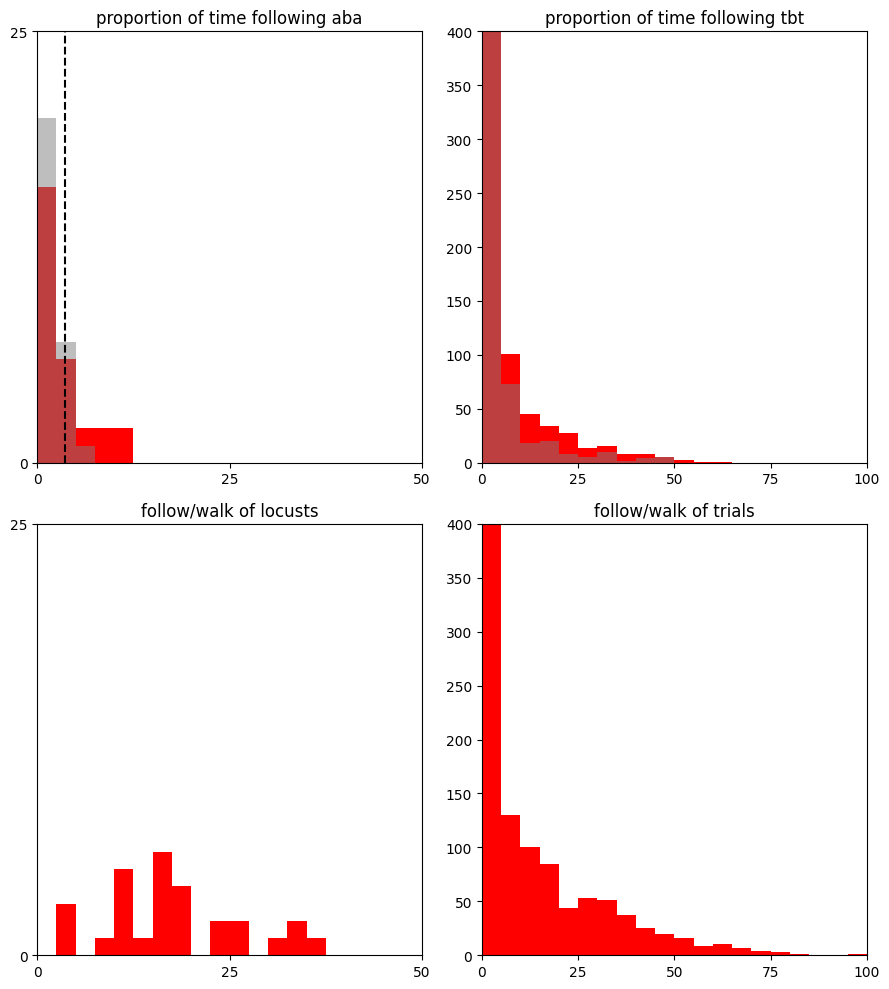

In [30]:
follow_time_aba,follow_time_tbt,_,_=plot_follow_response_distribution(all_evaluation)

In [ ]:
follow_time_aba,follow_time_tbt,_,_=plot_follow_response_distribution(all_evaluation[all_evaluation['speed']==2])

In [ ]:
gain_list=[0.25,0.5,1,2.0,4.0]
for this_gain in gain_list:
    follow_time_aba,follow_time_tbt,_,_=plot_follow_response_distribution(all_evaluation[all_evaluation['rotation_gain']==this_gain])

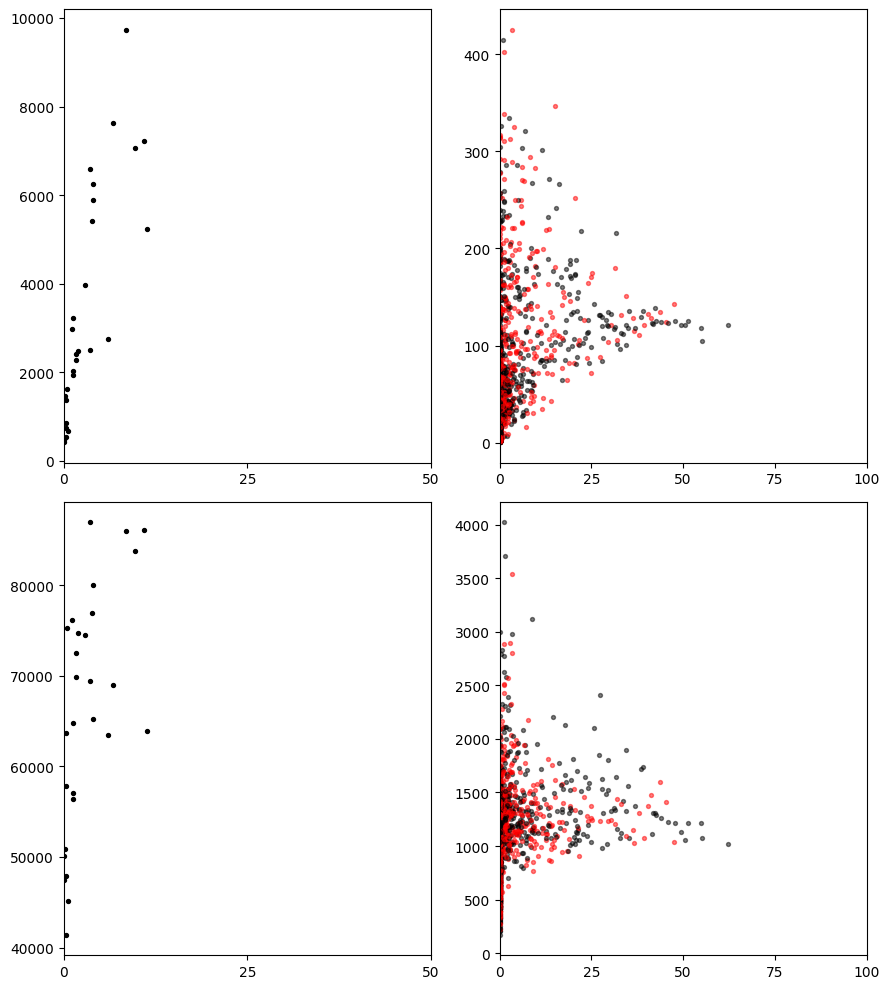

In [31]:
##plot the relationship between travel distance and proportion of following time
# print("first 1/3 best of followers:", np.quantile(follow_time_aba, 0.66))
# print("middle 1/3 best of followers:", np.quantile(follow_time_aba, 0.33))
camera_fps=analysis_methods.get("camera_fps")
fair_follower_threshold=np.quantile(follow_time_aba, 0.33)
good_follower_threshold=np.quantile(follow_time_aba, 0.66)
con_follow_time_list=[]
con_travel_distance_list=[]
exp_follow_time_list=[]
exp_travel_distance_list=[]
fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(9,10), tight_layout=True
    )
ax1, ax2, ax3, ax4 = axes.flatten()
ax1.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,0.5))
ax2.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,1))
for keys, this_data in all_evaluation.groupby(['animal_id']):
    p_follow=this_data['num_follow_epochs'].sum()/this_data['number_frames'].sum()
    if p_follow>good_follower_threshold:
        color='k'
    elif (p_follow>fair_follower_threshold) and (p_follow<good_follower_threshold):
        color='k'
    else:
        color='k'
    ax1.scatter(this_data['num_follow_epochs'].sum()/this_data['number_frames'].sum(),this_data['travel_distance'].sum(),c=color,s=8)
    ax3.scatter(this_data['num_follow_epochs'].sum()/this_data['number_frames'].sum(),this_data['total_turning'].sum(),c=color,s=8)
    # if p_follow>good_follower_threshold:
    #     pass
    # elif (p_follow>fair_follower_threshold) and (p_follow<good_follower_threshold):
    #     pass
    # else:
    #     continue
    for i,this_object in enumerate(sorted(this_data['object'].unique(), key=len)):
        these_num_follow_epochs=this_data['num_follow_epochs'][this_data['object']==this_object]
        these_num_frames=this_data['number_frames'][this_data['object']==this_object]
        these_travel_distance=this_data['travel_distance'][this_data['object']==this_object]
        these_total_turning=this_data['total_turning'][this_data['object']==this_object]
        if this_object=='mov_glocust' or this_object== "LeaderLocust":
            # ax2.scatter(these_num_follow_epochs/these_num_frames,these_travel_distance,c=color,s=8)
            # ax4.scatter(these_num_follow_epochs/these_num_frames,these_total_turning,c=color,s=8)
            ax2.scatter(these_num_follow_epochs/these_num_frames,these_travel_distance,c='k',s=8,alpha=0.5)
            ax4.scatter(these_num_follow_epochs/these_num_frames,these_total_turning,c='k',s=8,alpha=0.5)
            follow_time_ratio_tbt=these_num_follow_epochs/these_num_frames
            con_follow_time_list.append(follow_time_ratio_tbt.values)
            con_travel_distance_list.append(these_travel_distance.values)
        else:
            # ax2.scatter(these_num_follow_epochs/these_num_frames,these_travel_distance,edgecolors=color,marker='o', facecolors='none',s=8)
            # ax4.scatter(these_num_follow_epochs/these_num_frames,these_total_turning,edgecolors=color,marker='o', facecolors='none',s=8)
            ax2.scatter(these_num_follow_epochs/these_num_frames,these_travel_distance,c='r',s=8,alpha=0.5)
            ax4.scatter(these_num_follow_epochs/these_num_frames,these_total_turning,c='r',s=8,alpha=0.5)
            follow_time_ratio_tbt=these_num_follow_epochs/these_num_frames
            exp_follow_time_list.append(follow_time_ratio_tbt.values)
            exp_travel_distance_list.append(these_travel_distance.values)
ax3.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,0.5))
ax4.set(xticks=[0,0.25,0.5,0.75,1],xticklabels=(['0', '25', '50', '75', '100']),xlim=(0,1))
plt.show()

In [19]:
con_follow_time_arr=np.hstack(con_follow_time_list)
con_travel_distance_arr=np.hstack(con_travel_distance_list)
exp_follow_time_arr=np.hstack(exp_follow_time_list)
exp_travel_distance_arr=np.hstack(exp_travel_distance_list)
mean_con_follow_time=np.nanmean(con_follow_time_arr)
sem_con_follow_time=np.nanstd(con_follow_time_arr, ddof=1) / np.sqrt(con_follow_time_arr.shape[0])
mean_con_travel_distance=np.nanmean(con_travel_distance_arr)
sem_con_travel_distance=np.nanstd(con_travel_distance_arr, ddof=1) / np.sqrt(con_travel_distance_arr.shape[0])
mean_exp_follow_time=np.nanmean(exp_follow_time_arr)
sem_exp_follow_time=np.nanstd(exp_follow_time_arr, ddof=1) / np.sqrt(exp_follow_time_arr.shape[0])
mean_exp_travel_distance=np.nanmean(exp_travel_distance_arr)
sem_exp_travel_distance=np.nanstd(exp_travel_distance_arr, ddof=1) / np.sqrt(exp_travel_distance_arr.shape[0])

In [23]:
all_evaluation_grass=all_evaluation

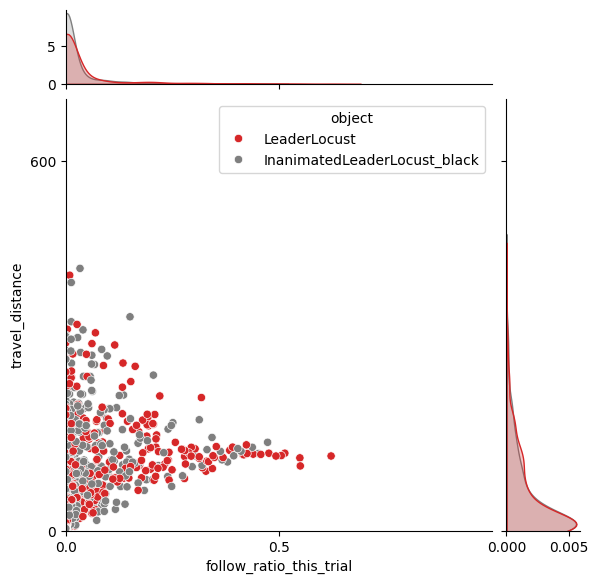

In [32]:
#fig, ax = plt.subplots(figsize=(3,3), dpi=300)
save_output=True
palette = {
    'InanimatedLeaderLocust_black': 'tab:grey',
    'LeaderLocust': 'tab:red',
}
svg_name = f"follow_time_vs_travel_distance.svg"
png_name = f"follow_time_vs_travel_distance.png"
sns.jointplot(data=all_evaluation, x="follow_ratio_this_trial", y="travel_distance", hue="object",palette=palette,marginal_ticks=True)
#sns.kdeplot(con_follow_time_arr, cut=0, color="b", fill=True, alpha=0.7)
plt.xlim(0, 1)
plt.xticks([0, 0.5])
plt.ylim(0,700)
plt.yticks([0,600])
if save_output==True:    
    plt.savefig(svg_name)
    plt.savefig(png_name)
# sns.pairplot(
#     all_evaluation,
#     x_vars=["follow_ratio_this_trial", "travel_distance","total_turning"],
#     y_vars=["follow_ratio_this_trial", "travel_distance","total_turning"],hue="object",palette=palette,corner=True)

In [ ]:
#sort data based on when the experiment is done
all_evaluation['batchs'] = pd.cut(all_evaluation['animal_id'], bins=3, labels=['1st', '2nd', '3rd'])
graph_colour_code =analysis_methods.get("graph_colour_code")
camera_fps=analysis_methods.get("camera_fps")
fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(9,10), tight_layout=True
    )
ax1, ax2 = axes.flatten()
for keys, grp in all_evaluation.groupby(['animal_id']):
    if grp['batchs'].values[0]=='1st':
        this_color=graph_colour_code[0]
    elif grp['batchs'].values[0]=='2nd':
        this_color=graph_colour_code[1]
    else:
        this_color=graph_colour_code[2]
    travel_distance=grp['travel_distance'].sum()/camera_fps
    total_turning=grp['total_turning'].sum()/camera_fps
    num_follow_epochs=grp['num_follow_epochs'].sum()/grp['number_frames'].sum()
    ax1.scatter(grp['num_follow_epochs'].sum()/grp['number_frames'].sum(),grp['travel_distance'].sum()/camera_fps,c=this_color,s=8)
    ax2.scatter(grp['num_follow_epochs'].sum()/grp['number_frames'].sum(),grp['total_turning'].sum()/camera_fps,c=this_color,s=8)
for keys, grp in all_evaluation.groupby(['batchs']):
    if grp['batchs'].values[0]=='1st':
        this_color=graph_colour_code[0]
    elif grp['batchs'].values[0]=='2nd':
        this_color=graph_colour_code[1]
    else:
        this_color=graph_colour_code[2]
    ax1.scatter(grp['num_follow_epochs'].sum()/grp['number_frames'].sum(),grp['travel_distance'].sum()/camera_fps/grp['animal_id'].unique().shape[0],edgecolors=this_color,s=20,facecolors='none')
    ax2.scatter(grp['num_follow_epochs'].sum()/grp['number_frames'].sum(),grp['total_turning'].sum()/camera_fps/grp['animal_id'].unique().shape[0],edgecolors=this_color,s=20,facecolors='none')

In [ ]:
#chop the data into 3 groups depends on time. Then we can analyse the 1st, 2nd and 3rd of the data
all_evaluation['time_group'] = pd.cut(all_evaluation['trial_id'], bins=3, labels=['1st', '2nd', '3rd'])
num_follow_list=[]
travel_distance_list=[]
for keys, grp in all_evaluation.groupby(['animal_id','time_group']):
    num_follow_list.append(grp["num_follow_epochs"].sum())
    travel_distance_list.append(grp["travel_distance"].sum())
num_follow_arr=np.array(num_follow_list).reshape(-1,3)
travel_distance_arr=np.array(travel_distance_list).reshape(-1,3)

In [ ]:
fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(9,10), tight_layout=True
    )
ax1, ax2 = axes.flatten()
ax1.plot(np.transpose(num_follow_arr), 'o-')
ax1.plot(np.mean(num_follow_arr,axis=0),'k',linewidth=5)
ax1.plot(np.median(num_follow_arr,axis=0),'k',linewidth=5,alpha=0.6)
ax2.plot(np.transpose(travel_distance_arr), 'o-')
ax2.plot(np.mean(travel_distance_arr,axis=0),'k',linewidth=5)
ax2.plot(np.median(travel_distance_arr,axis=0),'k',linewidth=5,alpha=0.6)

#### Section 2.3: Using 1D histogram to plot proportion of time and 2D histogram to plot relative position

In [10]:
all_trials=pd.concat(relative_pos_all_animals)
if len(simulated_relative_pos_all_animals)>0:
    all_simulated_trials=pd.concat(simulated_relative_pos_all_animals)

In [24]:
all_trials_grass=all_trials

In [ ]:

#### data with rotation gain and translation gain

extract_follow_epoches=analysis_methods.get("extract_follow_epoches",True)
distribution_with_entire_body=analysis_methods.get("distribution_with_entire_body",False)
#distribution_with_entire_body=False
fig, axes = plt.subplots(nrows=1, ncols=len(all_trials['rotation_gain'].unique()),figsize=(18, 6),tight_layout=True,sharex=True, sharey=True)
i=0
if extract_follow_epoches:
    xlimit=(-5,40)
    ylimit=(-15,15)
else:
    xlimit=(-20,100)
    ylimit=(-45,45)
for keys, grp in all_trials.groupby(['rotation_gain','translation_gain']):
        print(keys)
        if distribution_with_entire_body:
            body_points=generate_points_within_rectangles(grp['x'].values,grp['y'].values,1,4,2,21)
            axes[i].hist2d(body_points[:,0],body_points[:,1],bins=1000)
        else:
            axes[i].hist2d(grp['x'].values,grp['y'].values,bins=400)
        axes[i].set(
        yticks=[ylimit[0],0,ylimit[1]],
        xticks=[-5,0,4,20,40],
        xlim=xlimit,ylim=ylimit,title=f'rotation_gain:{keys[0]},translation_gain:{(keys[1])}',adjustable='box', aspect='equal')
        #rect = patches.Rectangle((0,-1), 6, 2, linewidth=1, edgecolor='red',linestyle="--",facecolor='none')
        #cir1 = patches.Circle((4,0), radius=0.5, linewidth=0.5, edgecolor='yellow')
        cir2 = patches.Circle((0,0), radius=0.4, linewidth=0.4, edgecolor='red',facecolor='red')
        #axes[i].add_patch(cir1)
        axes[i].add_patch(cir2)
        i=i+1
plt.show()

In [ ]:
extract_follow_epoches=analysis_methods.get("extract_follow_epoches",True)
distribution_with_entire_body=analysis_methods.get("distribution_with_entire_body",False)
fig, axes = plt.subplots(nrows=1, ncols=len(all_trials["type"].unique())*len(all_trials["degree"].unique()),figsize=(18, 6),tight_layout=True,sharex=True, sharey=True)
i=0
plotting_agent2focal=True
for keys, grp in all_trials.groupby(['type','degree']):
    if extract_follow_epoches:
        xlimit=(-5,40)
        ylimit=(-15,15)
    else:
        xlimit=(-20,100)
        ylimit=(-45,45)
    print(keys)
    if plotting_agent2focal:
        x=grp['x'].values*-1
        y=grp['y'].values*-1
        xticks_values=[-40,-20,-4,0,5]
        xlimit=(xlimit[1]*-1,xlimit[0]*-1)
    else:
        x=grp['x'].values
        y=grp['y'].values
        xticks_values=[-5,0,4,20,40]
        
    if distribution_with_entire_body:
        body_points=generate_points_within_rectangles(x,y,1,4,2,21)
        axes[i].hist2d(body_points[:,0],body_points[:,1],bins=1000)
    else:
        axes[i].hist2d(x,y,bins=400)
    axes[i].set(
    yticks=[ylimit[0],0,ylimit[1]],
    xticks=xticks_values,
    xlim=xlimit,ylim=ylimit,title=f'agent:{keys[0]},deg:{int(keys[1])}',adjustable='box', aspect='equal')
        #rect = patches.Rectangle((0,-1), 6, 2, linewidth=1, edgecolor='red',linestyle="--",facecolor='none')
        #cir1 = patches.Circle((4,0), radius=0.5, linewidth=0.5, edgecolor='yellow')
    cir2 = patches.Circle((0,0), radius=0.4, linewidth=0.4, edgecolor='red',facecolor='red')
        #axes[i].add_patch(cir1)
    axes[i].add_patch(cir2)
    i=i+1
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(all_simulated_trials["type"].unique())*len(all_simulated_trials["degree"].unique()),figsize=(18, 6),tight_layout=True,sharex=True, sharey=True)
i=0
if extract_follow_epoches:
    xlimit=(-5,40)
    ylimit=(-15,15)
else:
    xlimit=(-20,100)
    ylimit=(-45,45)
for keys, grp in all_simulated_trials.groupby(['type','degree']):
        if distribution_with_entire_body:
            body_points=generate_points_within_rectangles(grp['x'].values,grp['y'].values,1,4,2,21)
            axes[i].hist2d(body_points[:,0],body_points[:,1],bins=1000)
        else:
            axes[i].hist2d(grp['x'].values,grp['y'].values,bins=400)
        axes[i].set(
        yticks=[ylimit[0],0,ylimit[1]],
        xticks=[-5,0,4,20,40],
        xlim=xlimit,ylim=ylimit,title=f'agent:{keys[0]},deg:{int(keys[1])}',adjustable='box', aspect='equal')
        #rect = patches.Rectangle((0,-1), 6, 2, linewidth=1, edgecolor='red',linestyle="--",facecolor='none')
        #cir1 = patches.Circle((4,0), radius=0.5, linewidth=0.5, edgecolor='yellow')
        cir2 = patches.Circle((0,0), radius=0.4, linewidth=0.4, edgecolor='red',facecolor='red')
        #axes[i].add_patch(cir1)
        axes[i].add_patch(cir2)
        i=i+1
plt.show()

In [ ]:
##plot the distribution of follow epochs in a trial
##In the future, will use agent based model to show the temporal distribution
for keys, grp in all_trials.groupby(['type','degree']):
    sim_grp=all_simulated_trials[(all_simulated_trials['type']==keys[0])&(all_simulated_trials['degree']==keys[1])]
    print(keys)
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(9,5), tight_layout=True
    )
    ax, ax2 = axes.flatten()
    ax.hist(grp['ts'].values,bins=100,density=False,color='r')
    ax.hist(sim_grp['ts'].values,bins=100,density=False,color='tab:gray',alpha=0.3)
    ax2.hist(grp['ts'].values,bins=100,color='r',density=True,histtype="step",cumulative=True,label="Cumulative histogram")
    ax2.hist(sim_grp['ts'].values,bins=100,color='tab:gray',alpha=0.3,density=True,histtype="step",cumulative=True,label="Cumulative histogram")
    ax.set(xlim=(0,60),title=f'agent:{keys[0]},deg:{int(keys[1])}')
    ax.set(ylim=(0,2600))
plt.show()

In [ ]:
analysis_methods.update({"distribution_with_entire_body": True})

In [ ]:
from scipy.optimize import curve_fit
#https://stackoverflow.com/questions/78384537/fitting-2d-histograms-with-2d-gaussians
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, rho):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = 1 / sigma_x ** 2
    b = rho / sigma_x / sigma_y
    c = 1 / sigma_y ** 2
    exponent=  - (1 / (2 * (1 - rho ** 2)))\
                 * (a * (x - xo) ** 2 - 2 * b * (x - xo) * (y - yo) + c * (y - yo) ** 2)
    g = amplitude * np.exp(exponent)
    return g.ravel()

In [ ]:
nbr_bins = 100
B, xedges, yedges = np.histogram2d(grp['x'].values,grp['y'].values, bins=nbr_bins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
bin_centers_bx = (xedges[:-1] + xedges[1:]) / 2.0
bin_centers_by = (yedges[:-1] + yedges[1:]) / 2.0
X, Y = np.meshgrid(bin_centers_bx, bin_centers_by)
data = B.ravel()

In [ ]:
mean = [0, 4]
p0 = (B.max(),mean[0],mean[1],1.7,1.0,0.9)
coeff, var_matrix = curve_fit(twoD_Gaussian, (X, Y), data, p0=p0)
print('hist fit', coeff)
print('var_matrix', var_matrix)
data_fitted_hist = twoD_Gaussian((X, Y), *coeff)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

xlimit=(-30,30)
ylimit=(-30,30)
ax[0].imshow(data.reshape((nbr_bins, nbr_bins)), origin="lower",
             extent=extent, interpolation="none")
ax[1].imshow(data.reshape((nbr_bins, nbr_bins)), origin="lower",
             extent=extent, interpolation="none")
ax[1].contour(X, Y, data_fitted_hist.reshape(nbr_bins, nbr_bins), 2, colors="w",linestyles='dashed',linewidths=0.5)
ax[0].set(
        yticks=[-30,0.0,30],
        xticks=[-30,0.0,30],
        xlim=xlimit,ylim=ylimit)
ax[1].set(
        yticks=[-30,0.0,30],
        xticks=[-30,0.0,30],
        xlim=xlimit,ylim=ylimit)

calculate median velocity vector


c:\Users\neuroLaptop\Documents\GitHub\UnityDataAnalysis\sorting_time_series_analysis.py:158: UserWarning: Adding colorbar to a different Figure <Figure size 600x500 with 2 Axes> than <Figure size 600x900 with 4 Axes> which fig.colorbar is called on.
  ax1.set(xlabel='averaged speed in vector field (cm/s)',


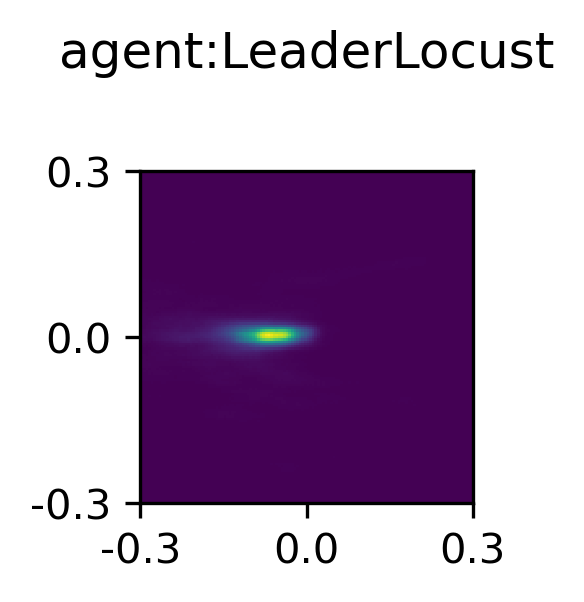

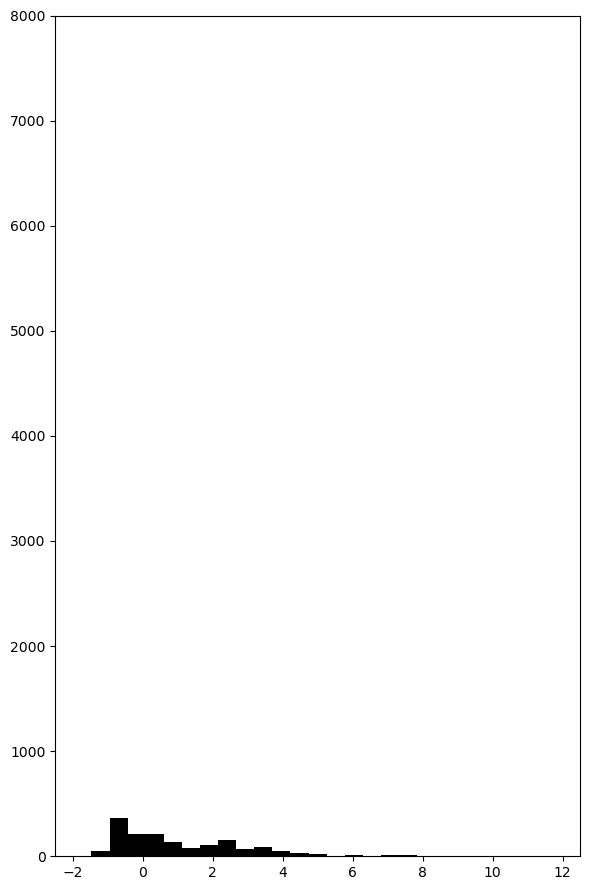

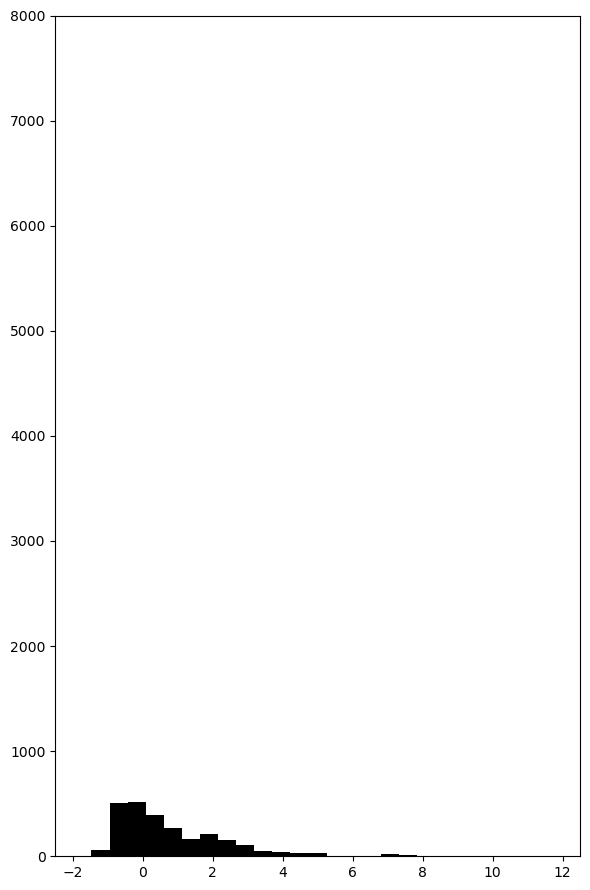

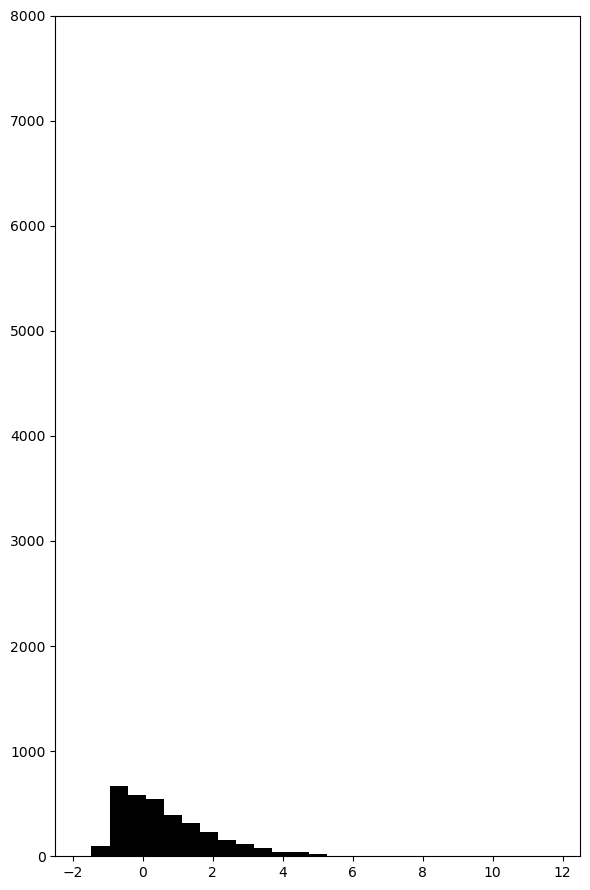

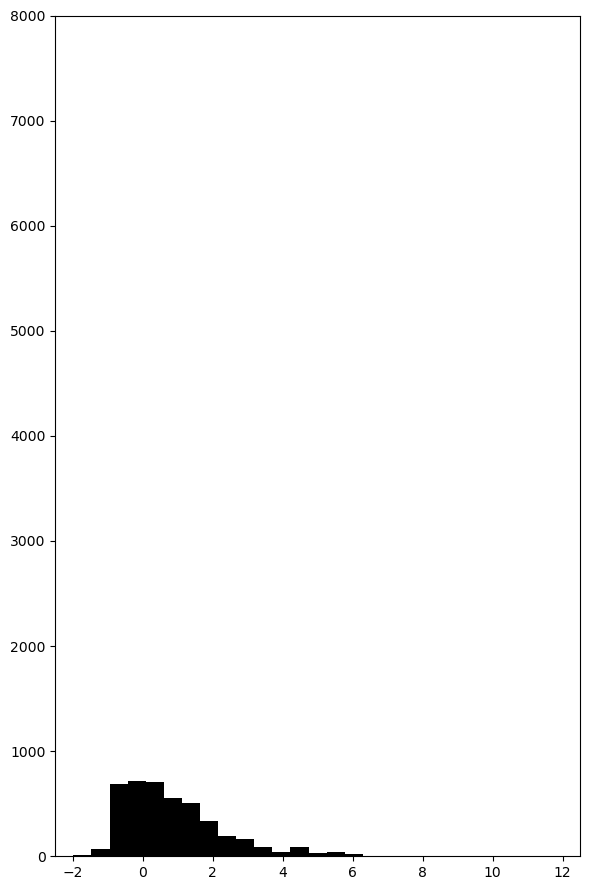

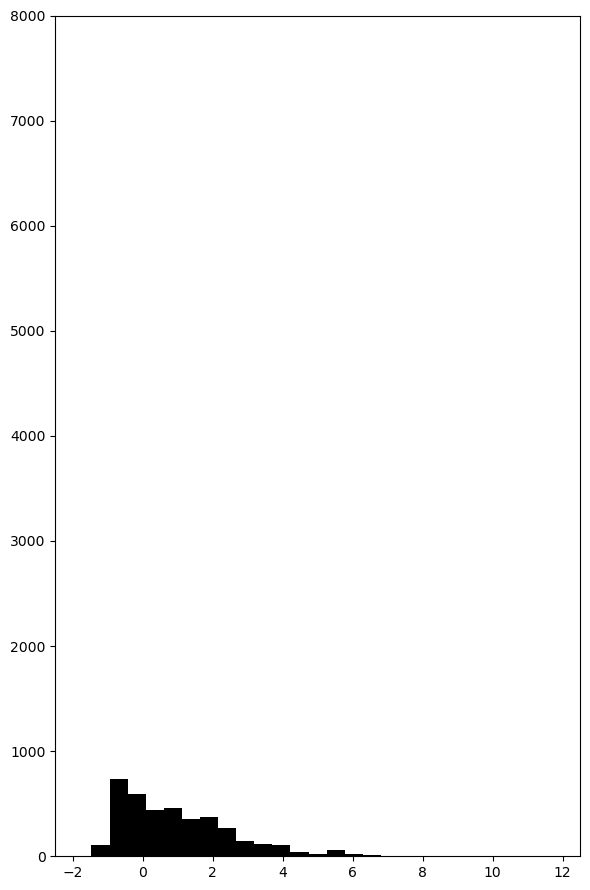

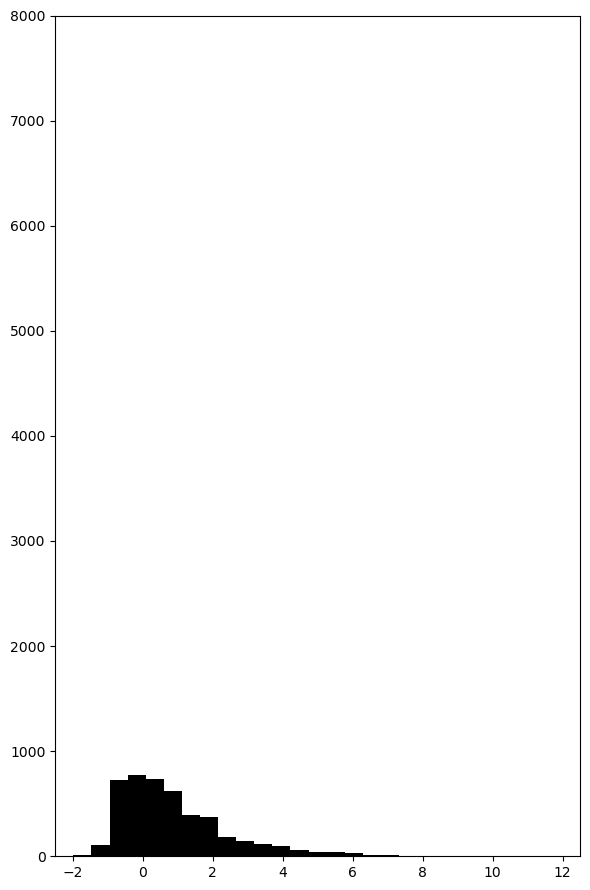

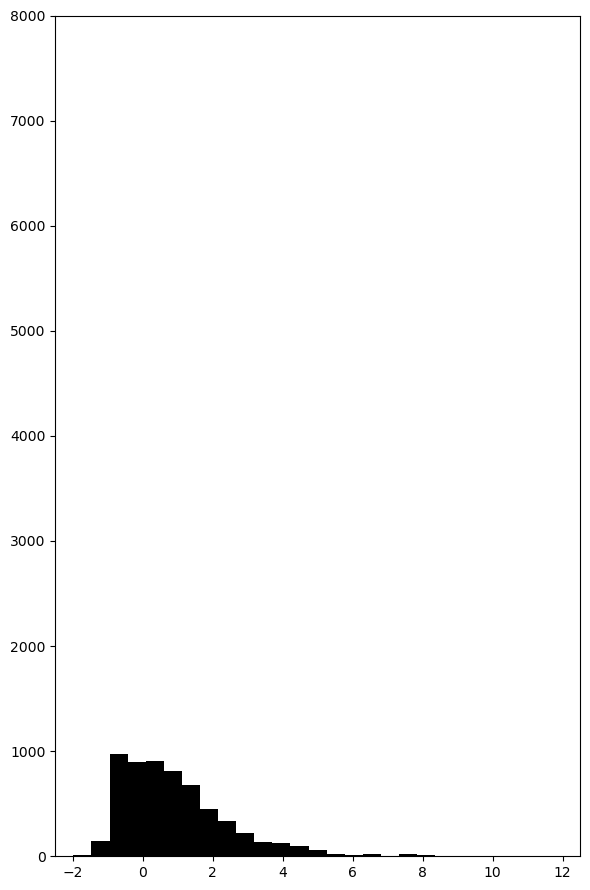

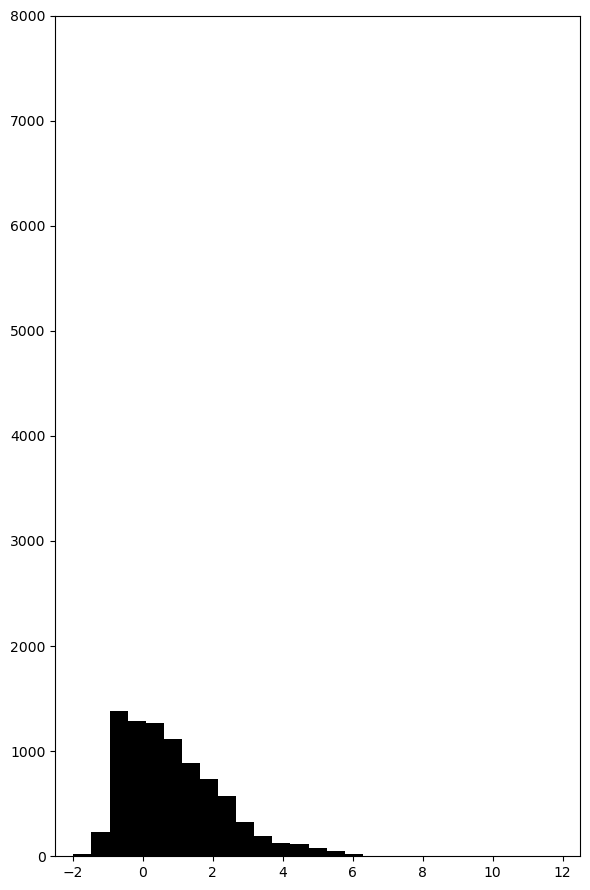

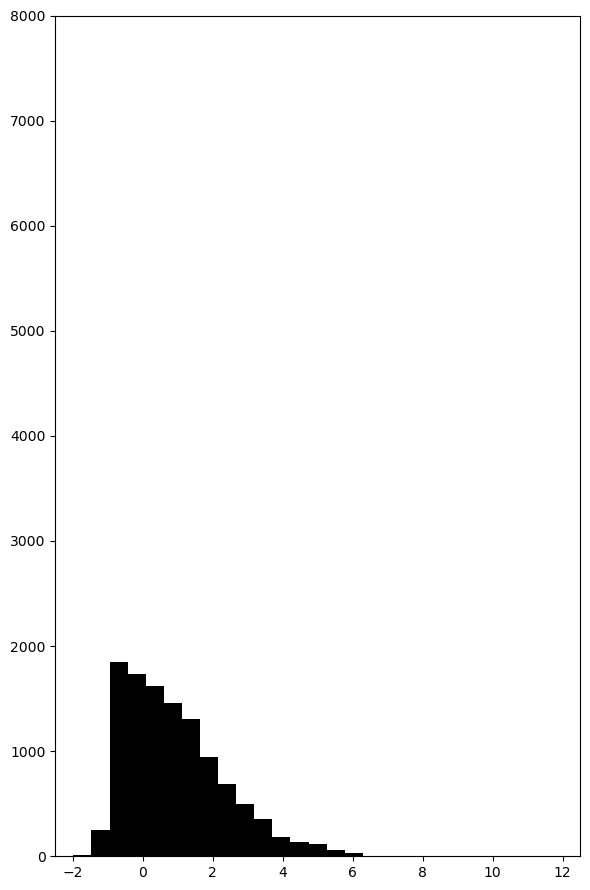

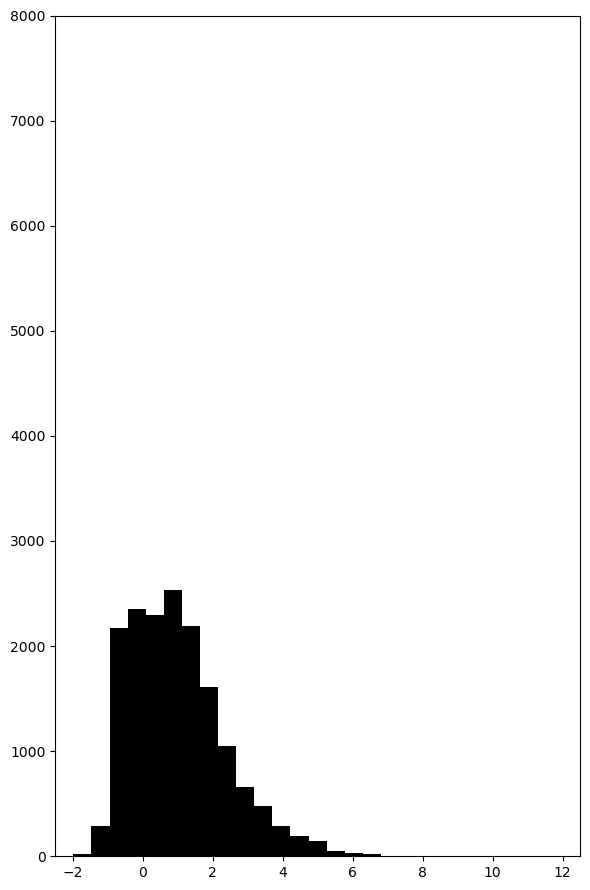

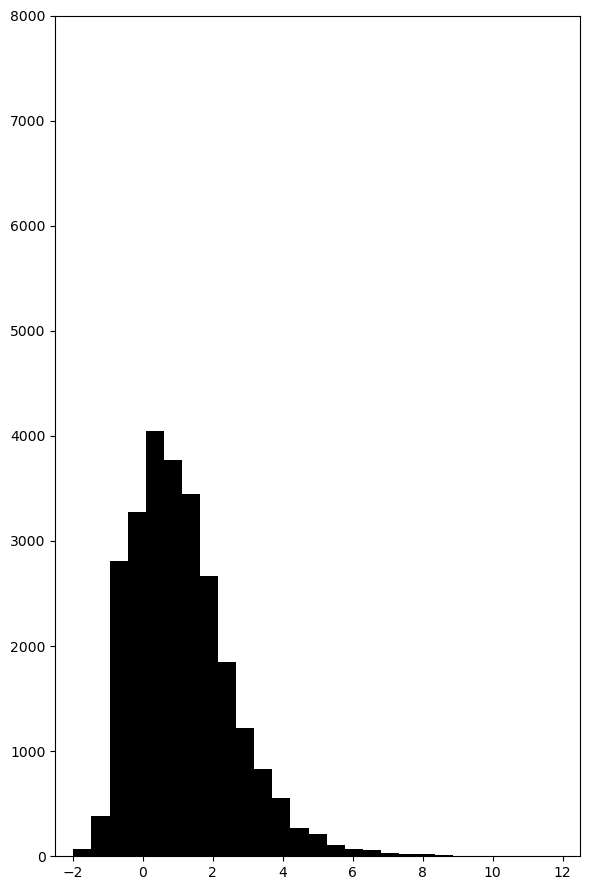

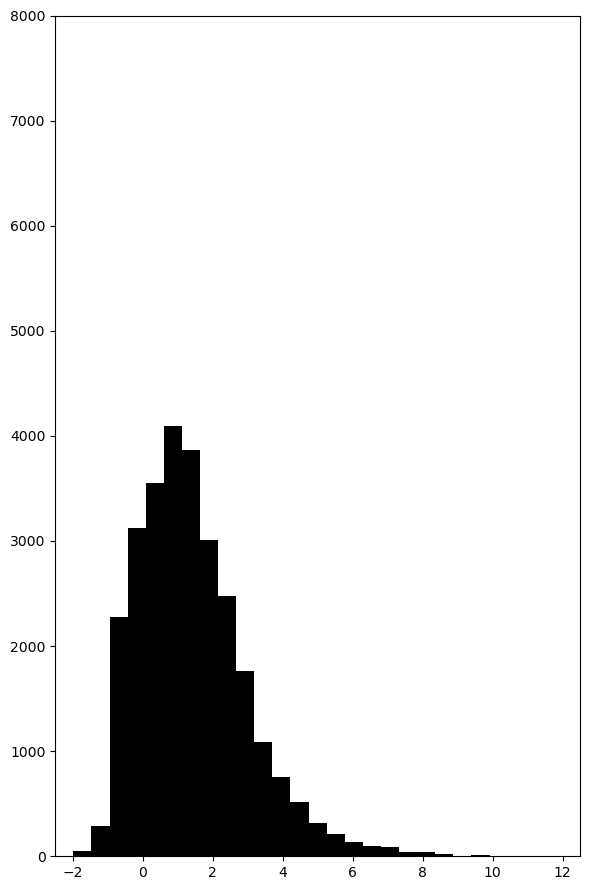

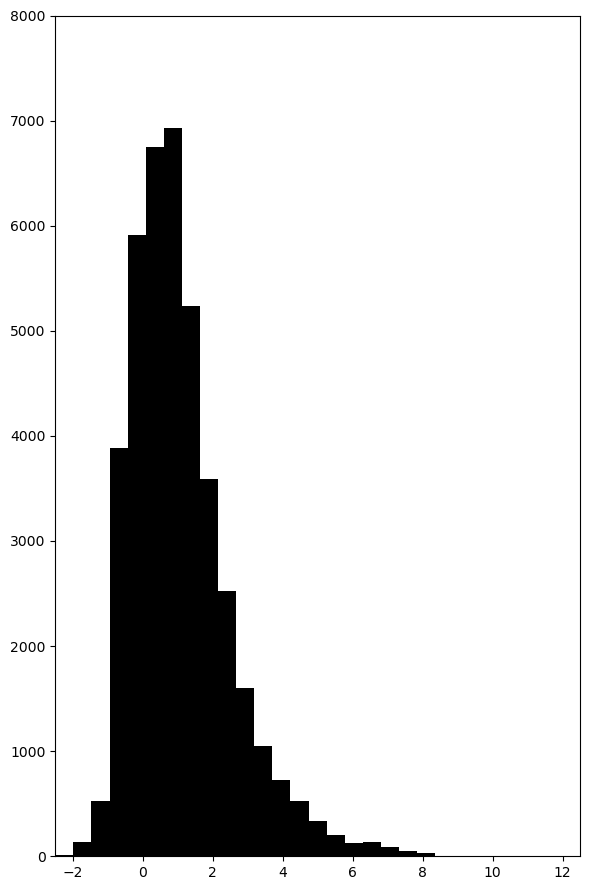

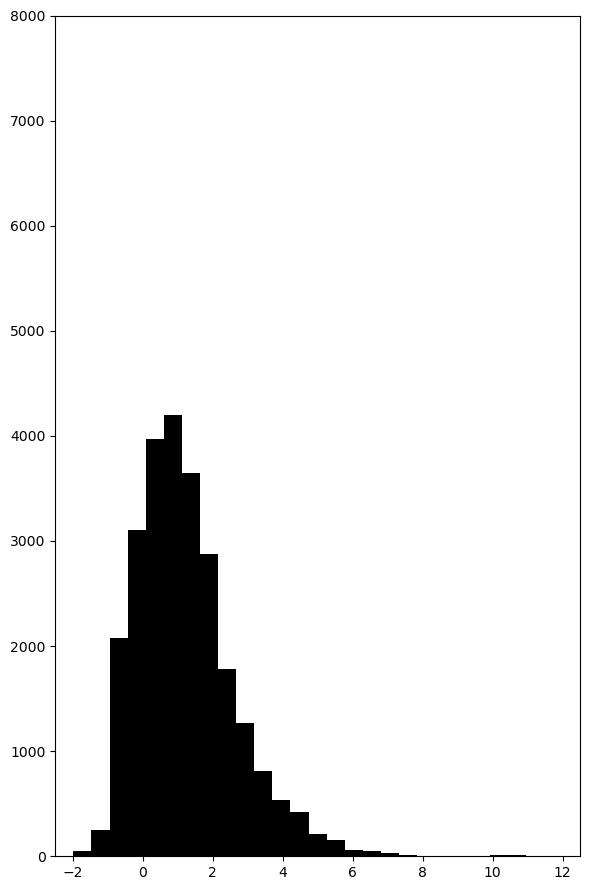

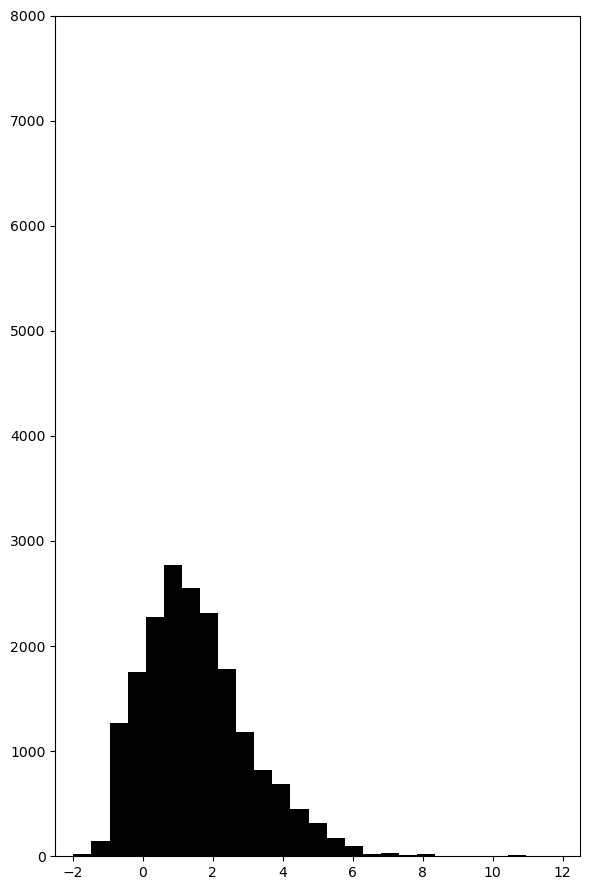

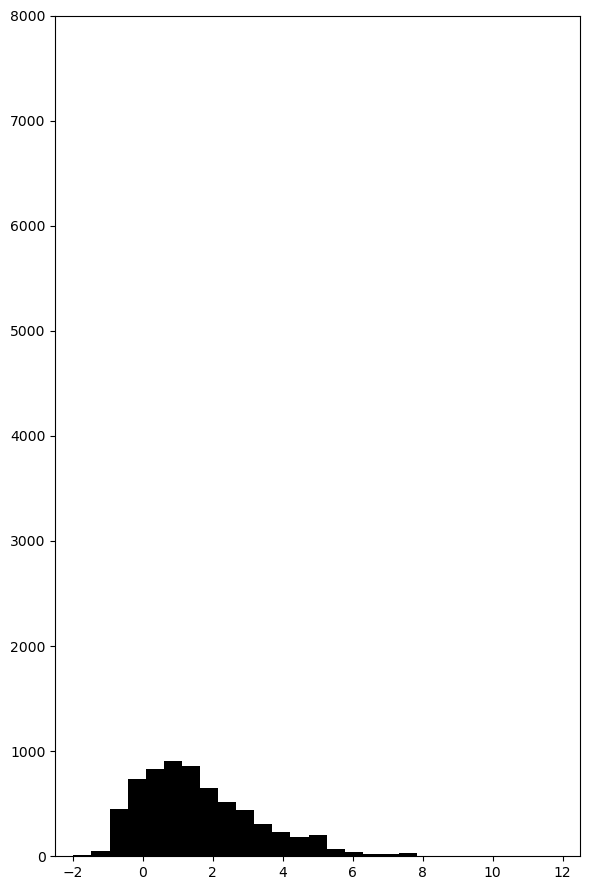

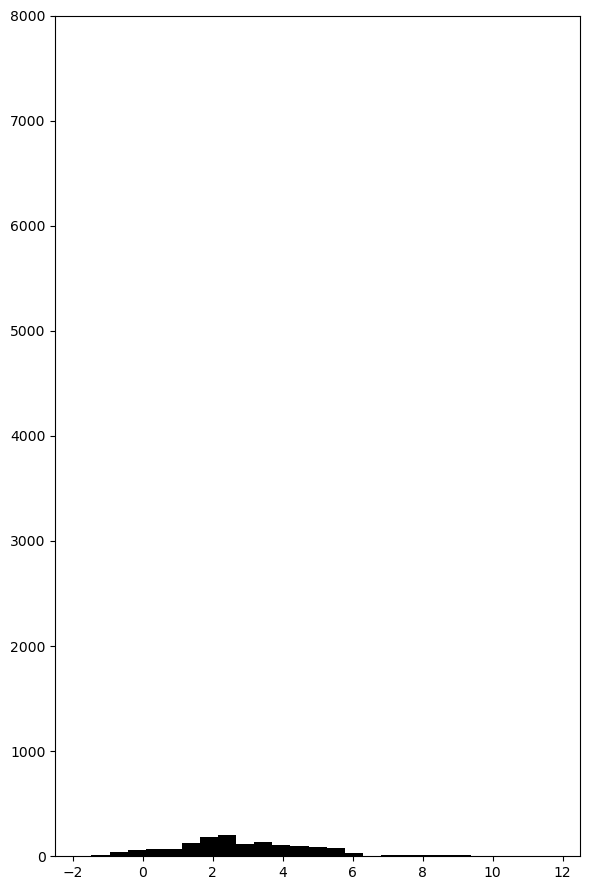

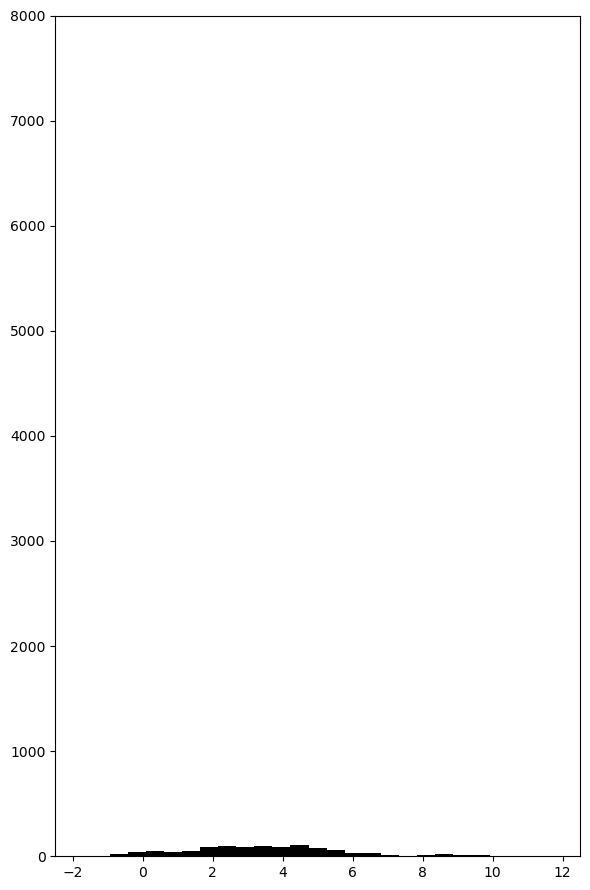

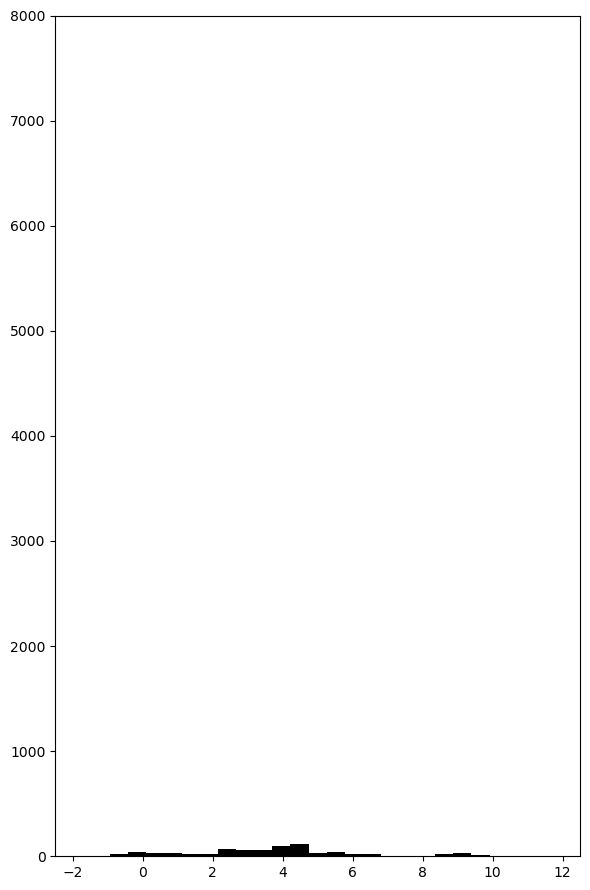

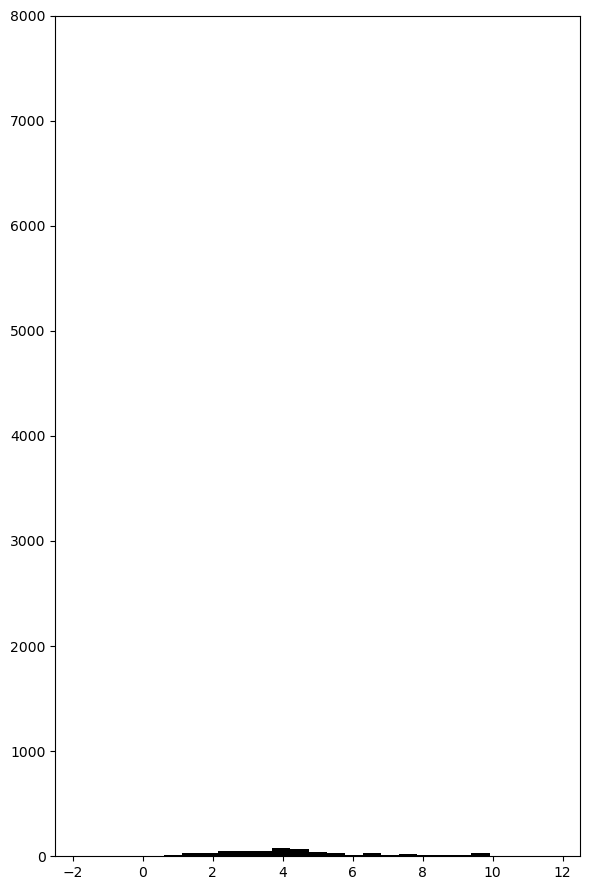

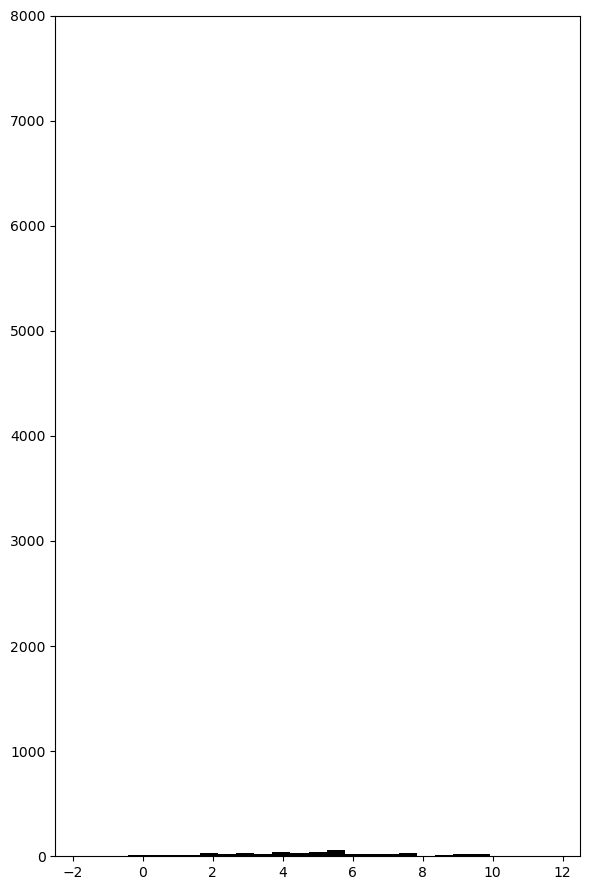

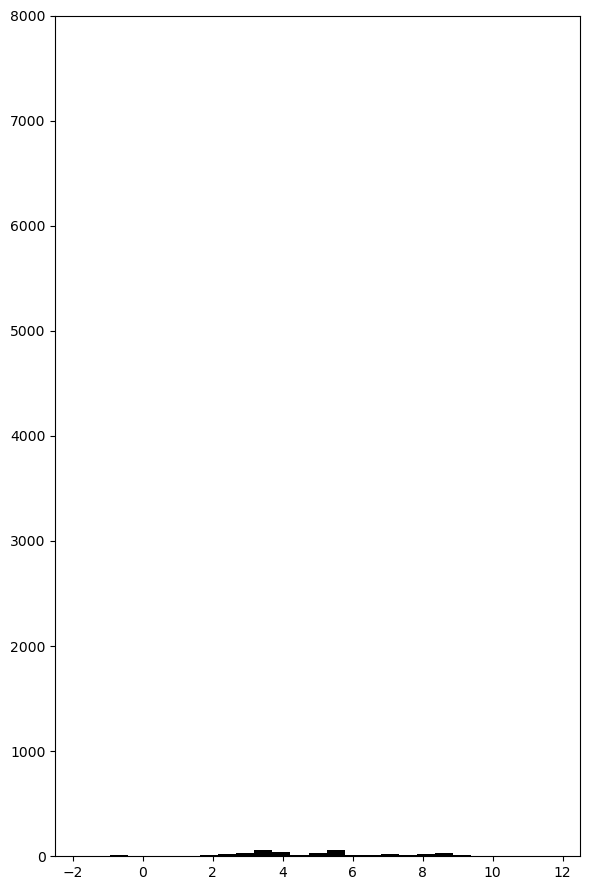

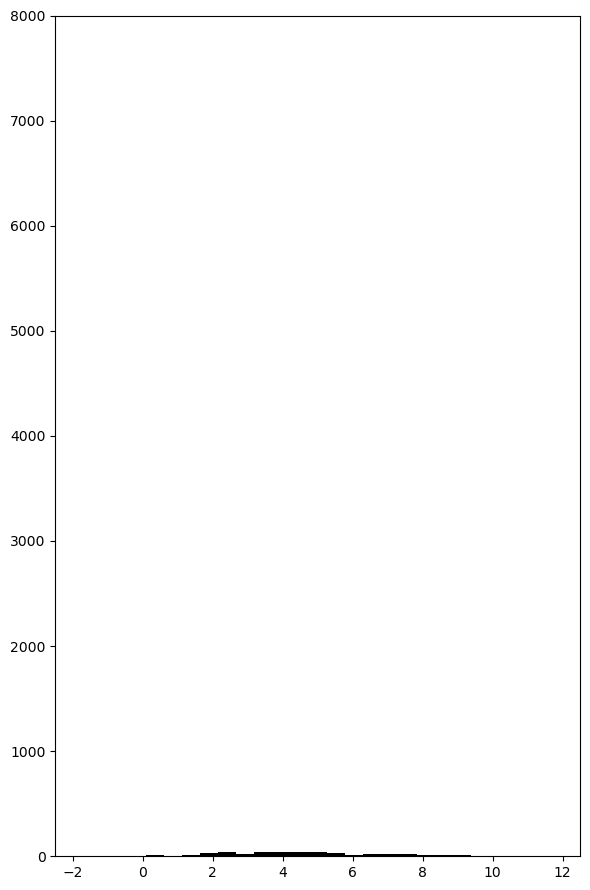

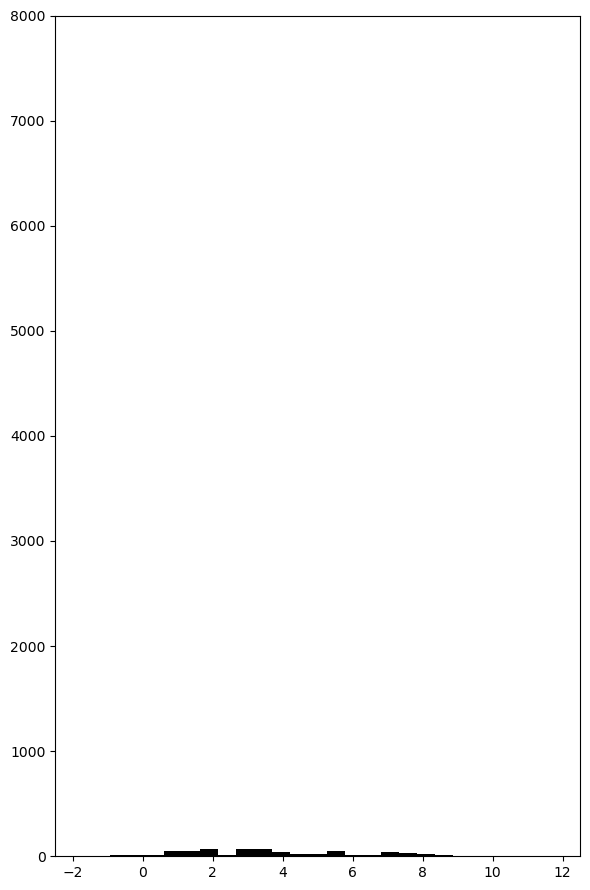

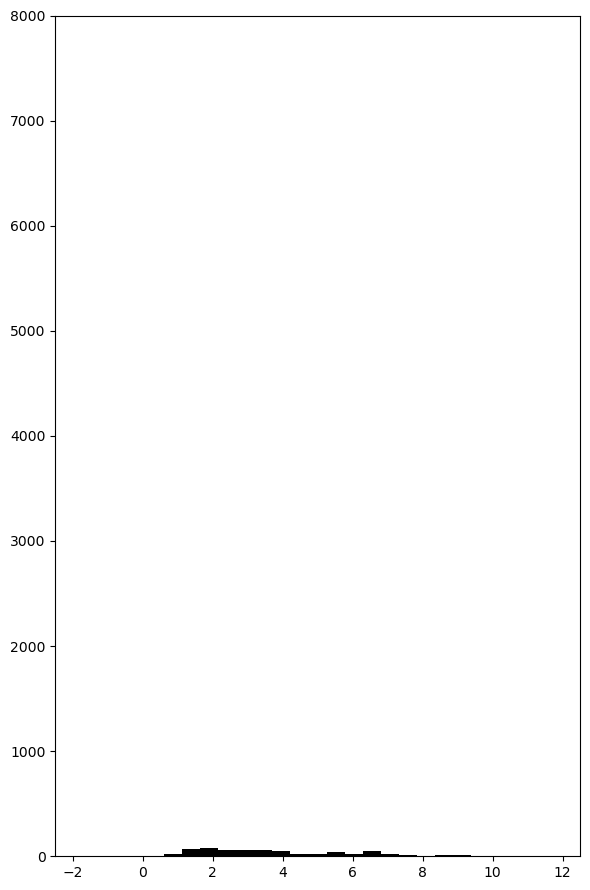

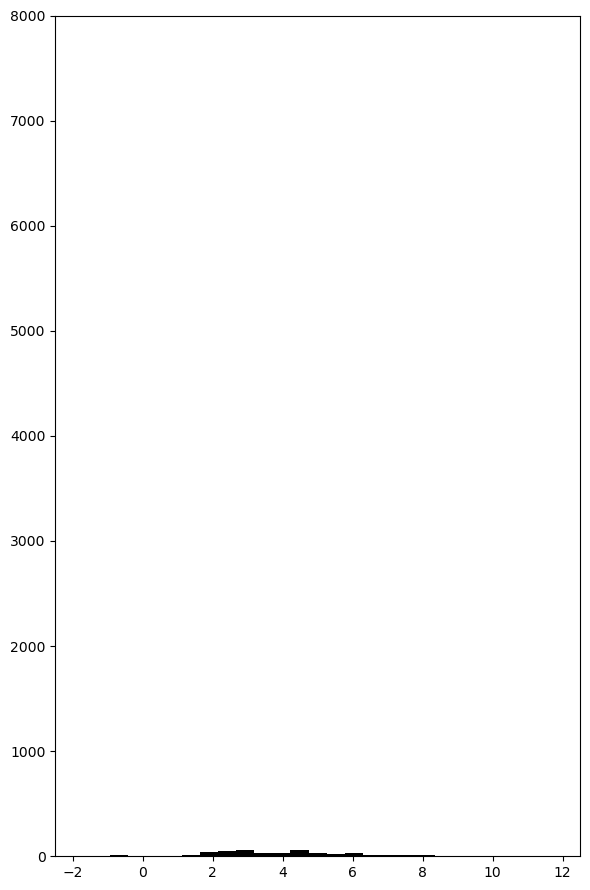

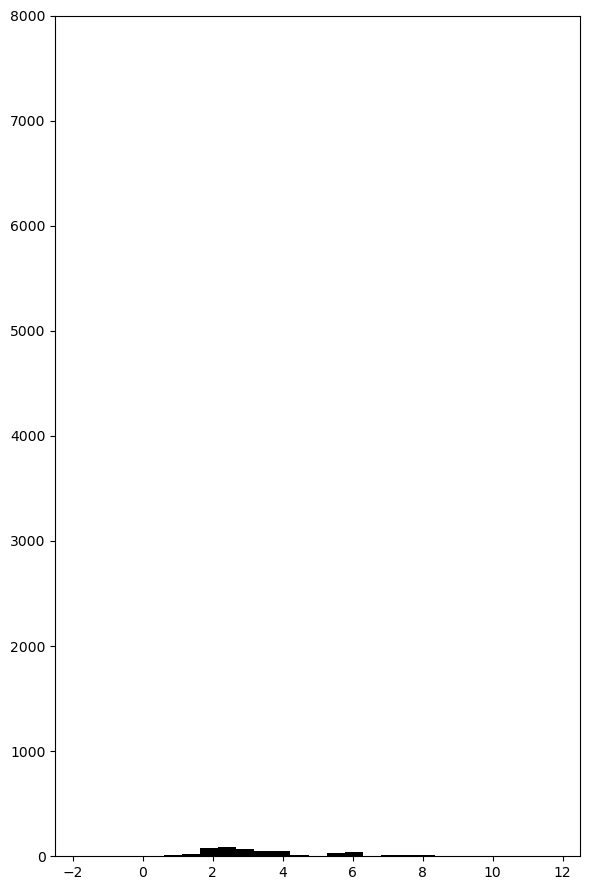

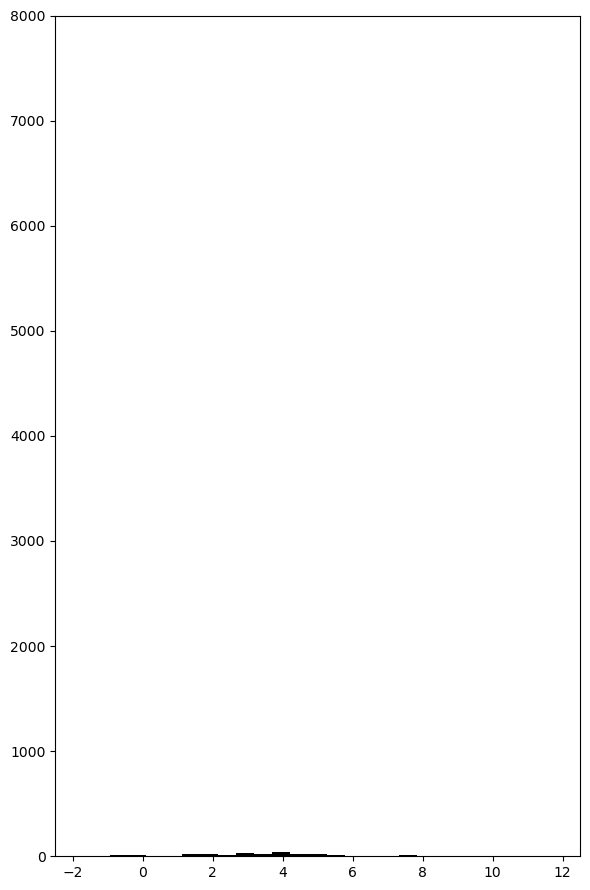

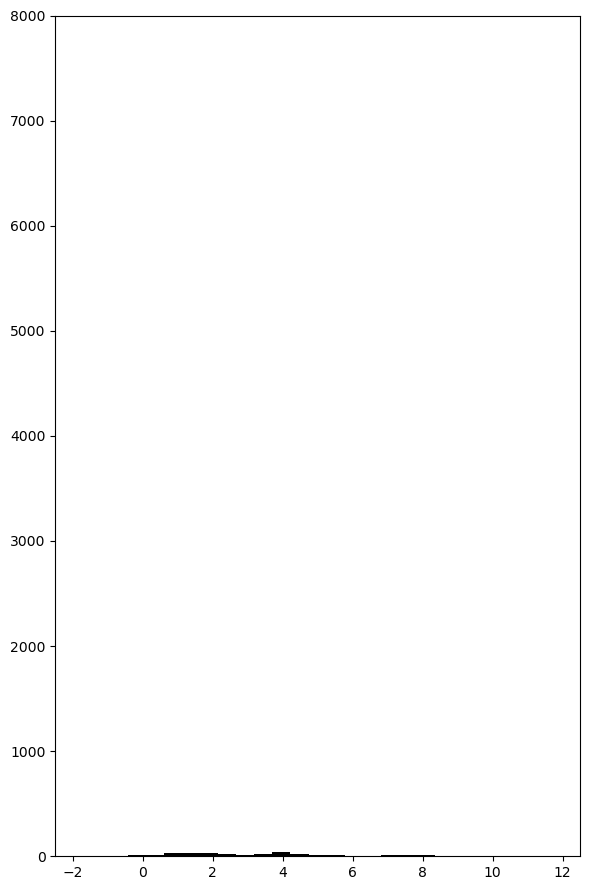

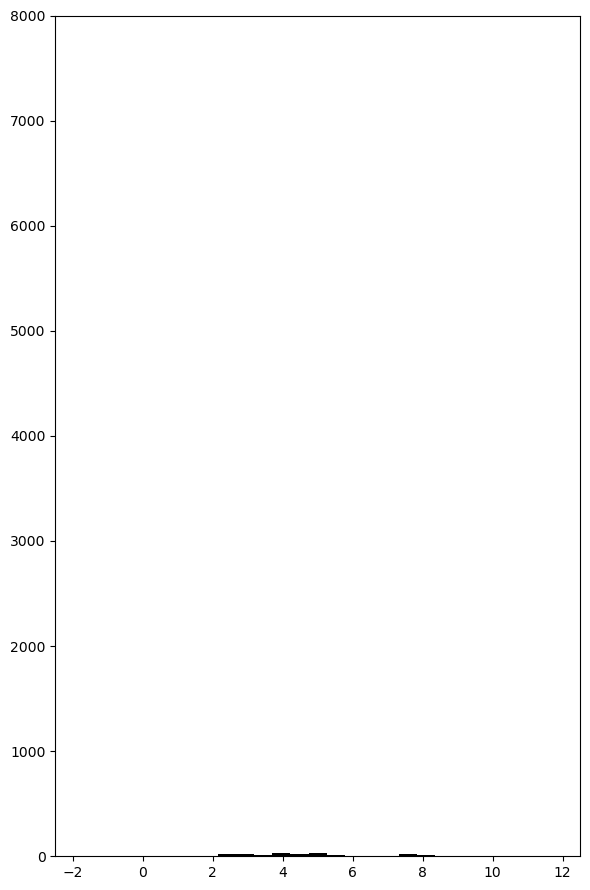

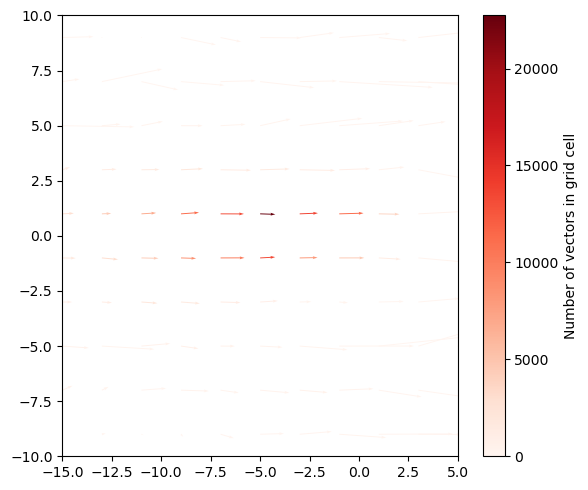

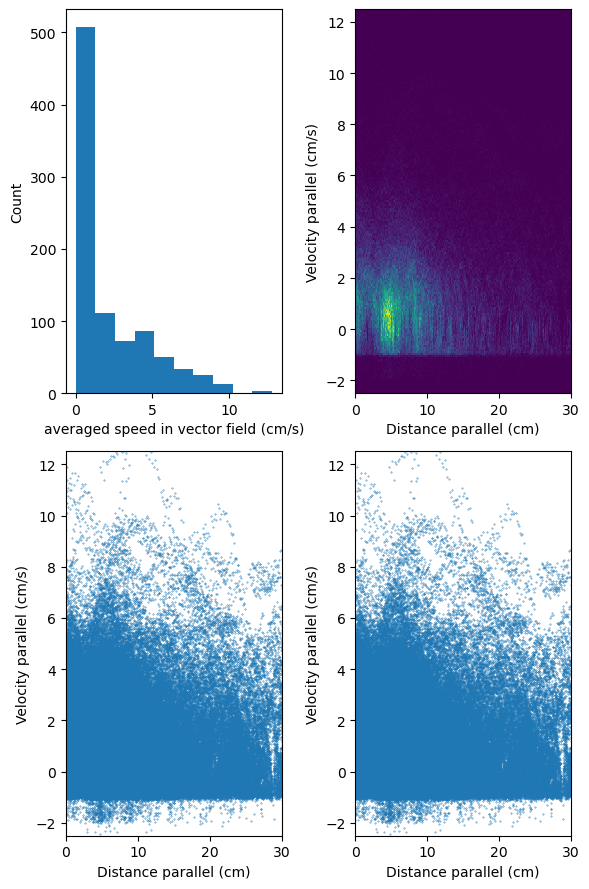

In [18]:
##plot the spatial distribution of virtual locusts in a 2D histogram
plotting_agent2focal=True
analysis_methods.update({"distribution_with_entire_body":True})
distribution_with_entire_body=analysis_methods.get("distribution_with_entire_body",True)
extract_follow_epoches=analysis_methods.get("extract_follow_epoches",True)



if extract_follow_epoches:
    xlimit=ylimit=(-30,30)
else:
    xlimit=(-20,100)
    ylimit=(-45,45)
for keys, grp in all_trials.groupby(['type']):
    fig, ax = plt.subplots(nrows=1, ncols=1,tight_layout=True,dpi=300,figsize=(4,2))
    if plotting_agent2focal:
        x=grp['x'].values*-1
        y=grp['y'].values*-1
        xticks_values=[-40,-20,-4,0,5]
        xlimit=(xlimit[1]*-1,xlimit[0]*-1)
    else:
        x=grp['x'].values
        y=grp['y'].values
    if distribution_with_entire_body:
        body_points=generate_points_within_rectangles(x,y,1,4,2,21)
        ax.hist2d(body_points[:,0],body_points[:,1],bins=225)
    else:
        ax.hist2d(x,y,bins=225)
    ax.set(
        adjustable='box', aspect='equal',
        yticks=[-30,0.0,30],
        xticks=[-30,0.0,30],
        xticklabels=(['-0.3', '0.0', '0.3']),
        yticklabels=(['-0.3', '0.0', '0.3']),
        xlim=xlimit,ylim=ylimit)
    '''
    the position of virtual locust if their butt is at the origin
    rect = patches.Rectangle((0,-1), 6, 2, linewidth=1, edgecolor='red',linestyle="--",facecolor='none')
    ax.add_patch(rect)
    '''
    #cir = patches.Circle((0,0), radius=0.5, linewidth=0.5, edgecolor='red')
    #ax.add_patch(cir)
    fig.suptitle(f'agent:{keys[0]}')
    _,_=plot_velocity_vector_field(grp)
plt.show()

##### section 2.3.5 plot velocity vector field

In [ ]:
_,_=plot_velocity_vector_field(all_trials)

#### Section 2.4: Plot temporal distribution of follow epoch throughout the trial course

In [ ]:
##plot the temporal distribution of follow epochs in a trial
for keys, grp in all_trials.groupby(['type']):
    print(keys)
    sim_grp=all_simulated_trials[all_simulated_trials['type']==keys[0]]
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(9,5), tight_layout=True
    )
    ax, ax2 = axes.flatten()
    ax.hist(grp['ts'].values,bins=100,density=False,color='r')
    ax.hist(sim_grp['ts'].values,bins=100,density=False,color='tab:gray',alpha=0.5)
    ax2.hist(grp['ts'].values,bins=100,density=True,color='r',histtype="step",cumulative=True,label="Cumulative histogram")
    ax2.hist(sim_grp['ts'].values,bins=100,color='tab:gray',alpha=0.5,density=True,histtype="step",cumulative=True,label="Cumulative histogram")
    ax.set(xlim=(0,60))
plt.show()

#### Section 2.5: estimation analysis

In [ ]:
# this cell is for dabest analysis. However, it is not good for experiment design with multiple trials
# import dabest
# con_follow_time_arr=np.hstack(con_follow_time_list)
# exp_follow_time_arr=np.hstack(exp_follow_time_list)
# dabest_pd = pd.DataFrame({"Control": con_follow_time_arr, "Test": exp_follow_time_arr})
# two_groups_unpaired = dabest.load(dabest_pd, idx=("Control", "Test"))
# two_groups_unpaired.mean_diff.plot()
''' a format that seperates trials and animals. Rows are animals and columns are trials
c_name_list=column_name_list(con_follow_time_list[0].shape[0],'con')
tmp = pd.DataFrame(con_follow_time_list,columns=c_name_list)
c_name_list=column_name_list(exp_follow_time_list[0].shape[0],'exp')
tmp2 = pd.DataFrame(exp_follow_time_list,columns=c_name_list)
df_combined=pd.concat([tmp.reset_index(drop=True), tmp2.reset_index(drop=True)], axis=1)
df_combined=df_combined.reset_index(names='ID')
'''

#### Section 2.6: Exporting dataset into Mat or csv

In [ ]:
##save the raw data into mat file for matlab
from scipy.io import savemat
all_raw=pd.concat(relative_pos_all_animals)
#all_raw['trial_id']=all_raw['trial_id'].astype(int)
data_dict = {name: col.values for name, col in all_raw.items()}
summary_file_name = Path(thisDataset) /"time_series_curated.mat"
savemat(summary_file_name, data_dict)

In [ ]:
## A helper function to export the data into csv file
def summarise_as_csv(input_list,agent_type='glocust'):
    df=pd.DataFrame(np.hstack(input_list))
    df.insert(0, 'agent_type', np.repeat(agent_type,df.shape[0]).tolist())
    df.insert(0, 'ID', np.repeat(np.arange(len(input_list)),int(df.shape[0]/len(input_list))).tolist())
    df.to_csv(f'{agent_type}.csv')
def summarise_as_csv2(list1,list2,type1='gregarious_locust',type2='black_locust'):
    df=pd.DataFrame({"ratio":np.concat([np.hstack(list1),np.hstack(list2)])})
    df.insert(0, 'agent_type', np.concat((np.repeat(type1,len(list1)*list1[0].shape[0]),np.repeat(type2,len(list2)*list2[0].shape[0]))).tolist())
    df.insert(0, 'times',np.repeat(np.tile(np.arange(exp_follow_time_list[0].shape[0]),len(exp_follow_time_list)),2).tolist())
    df.insert(0, 'ID', np.repeat(np.repeat(np.arange(len(exp_follow_time_list)),exp_follow_time_list[0].shape[0]),2).tolist())
    df.to_csv(f'{type1}_vs_{type2}_repeated_measure.csv')
#summarise_as_csv(exp_follow_time_list,'exp_agent')
#summarise_as_csv(con_follow_time_list)
summarise_as_csv2(con_follow_time_list,exp_follow_time_list,'con','exp')

### Section 3.0: analysis walking behavours before and after the presence of stimulus

#### Session 3.1: combine list together and check their distribution to look for a threshold that separate stationary and behavioural states.

In [ ]:
if type(raster_across_animals_unity)==list:
    all_trials=pd.concat(raster_across_animals_unity)
    all_trials=fix_data_type(all_trials)
else:
    all_trials=fix_data_type(raster_across_animals_unity)

In [ ]:
metrics_name='omega'
check_baseline_distribution(all_trials,analysis_methods,metrics_name,3)
# check_baseline_distribution(all_trials,analysis_methods)

#### Session 3.2: split trials based on stationary and moving state and retrieve their index

In [ ]:
#for simplicity, classifying trial only based on stationary and walk trails
classify_trials=False
trial_classfier='velocity'#'velocity' or 'omega'
metrics_name='omega'#'velocity' or 'omega'
_,these_metrics,these_normalised_metrics=split_trials(analysis_methods,all_trials,metrics_name,'normalised_omega',1)#1 degree or 0.0002 rad
if classify_trials:
    movement_trial_boolean,_,_=split_trials(analysis_methods,all_trials,trial_classfier)
else:
    movement_trial_boolean=[True]*len(these_metrics)

In [ ]:
#movement_trial_boolean,these_metrics,these_normalised_metrics=split_trials(analysis_methods,all_trials)

In [ ]:
after_movement_ith_trial,after_no_movement_ith_trial=extract_trial_index(movement_trial_boolean,len(all_trials['animal_id'].unique()),analysis_methods)

#### Session 3.3: select animals or trial of interest (related to follow response)

In [ ]:
##criteria to sort out data from good followers
# fair_follower_threshold=0.20
#fair_follower_threshold=0.1667
# good_follower_threshold=0.3
#data from grass1 secene
# first 1/3 best of followers: 0.04542389707280022
# middle 1/3 best of followers: 0.024365961537554066
def select_animal_or_trial_to_analyse(all_evaluation,use_aba_threshold,based_on_follow_walk_ratio,threshold_value=0.25):
    if based_on_follow_walk_ratio:
        denominator='num_walk_epochs'
    else:
        denominator='number_frames'
    if use_aba_threshold==True:
        p_follow=all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])[denominator].sum()
        #follower_of_interest=(p_follow>fair_follower_threshold) & (p_follow<good_follower_threshold)
        #data_of_interest=p_follow>0.14 ### this data of interest means subjects of interest
        data_of_interest=p_follow>threshold_value
        #rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
    else:
        data_of_interest=all_evaluation['num_follow_epochs']/all_evaluation[denominator]>threshold_value
        #data_of_interest=(all_evaluation['num_follow_epochs']/all_evaluation[denominator]<threshold_value)&(all_evaluation['num_follow_epochs']/all_evaluation[denominator]>0.1)
    return data_of_interest

In [ ]:
use_aba_threshold=True
based_on_follow_walk_ratio=True
data_of_interest=select_animal_or_trial_to_analyse(all_evaluation,use_aba_threshold,based_on_follow_walk_ratio,0)

In [ ]:
data_of_interest=select_animal_or_trial_to_analyse(all_evaluation[all_evaluation['speed']==2],use_aba_threshold,based_on_follow_walk_ratio)

In [ ]:
##these vars are for the experiment "sta_black_locust_2dir_3_initial_position"
#var1='radial_distance'
#var2='mu'
##these vars are for the experiment "closed_loop_sta_black_locust_open_loop_sta_black_locust"
var1='speed'
var2='mu'
##this is for the experiment "choice_vr_locust_sta_black_locust"
# if all_evaluation['object'].unique().shape[0]>1:
# var1='object'
# var2='mu'
var1='mu'

#### Session 3.4: plot the results

In [ ]:
for type_key in all_evaluation[var1].unique():
    print(type_key)
    if use_aba_threshold==True:
        rows_of_follower=data_of_interest.repeat(int(all_evaluation.shape[0]/data_of_interest.shape[0]))
    if "var2" in locals():
        for this_condition in all_evaluation[var2].unique():
            print(this_condition)
            if use_aba_threshold==True:
                row_of_interest=(all_evaluation[var2].reset_index(drop=True)==this_condition)&(all_evaluation[var1].reset_index(drop=True)==type_key)&(rows_of_follower.reset_index(drop=True))
            else:
                row_of_interest=(all_evaluation[var2].reset_index(drop=True)==this_condition)&(all_evaluation[var1].reset_index(drop=True)==type_key)&(data_of_interest.reset_index(drop=True))
            plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,metrics_name,row_of_interest,type_key,this_condition)
    else:
        if use_aba_threshold==True:
            row_of_interest=(all_evaluation[var1].reset_index(drop=True)==type_key)&rows_of_follower.reset_index(drop=True)
        else:
            row_of_interest=(all_evaluation[var1].reset_index(drop=True)==type_key)&(data_of_interest.reset_index(drop=True))
        plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,metrics_name,row_of_interest,type_key)

In [ ]:
for type_key in all_evaluation[var1].unique():
    print(type_key)
    if use_aba_threshold==True:
        rows_of_follower=data_of_interest.repeat(int(all_evaluation.shape[0]/data_of_interest.shape[0]))
    for this_condition in all_evaluation[var2].unique():
        print(this_condition)
        if use_aba_threshold==True:
            row_of_interest=(all_evaluation[var2].reset_index(drop=True)==this_condition)&(all_evaluation[var1].reset_index(drop=True)==type_key)&(rows_of_follower.reset_index(drop=True))
        else:
            row_of_interest=(all_evaluation[var2].reset_index(drop=True)==this_condition)&(all_evaluation[var1].reset_index(drop=True)==type_key)&(data_of_interest.reset_index(drop=True))
        plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,metrics_name,row_of_interest,type_key,this_condition)

In [ ]:
#for simplicity, classifying trial only based on stationary and walk trails
classify_trials=True
trial_classfier='velocity'#'velocity' or 'omega'
metrics_name='velocity'#'velocity' or 'omega'
_,these_metrics,these_normalised_metrics=split_trials(analysis_methods,all_trials)
if classify_trials:
    movement_trial_boolean,_,_=split_trials(analysis_methods,all_trials,trial_classfier)
else:
    movement_trial_boolean=[True]*len(these_metrics)
after_movement_ith_trial,after_no_movement_ith_trial=extract_trial_index(movement_trial_boolean,len(all_trials['animal_id'].unique()),analysis_methods)

In [ ]:
metrics_name='velocity'
for type_key in all_evaluation[var1].unique():
    print(type_key)
    if use_aba_threshold==True:
        rows_of_follower=data_of_interest.repeat(int(all_evaluation.shape[0]/data_of_interest.shape[0]))
    for this_condition in all_evaluation[var2].unique():
        print(this_condition)
        if use_aba_threshold==True:
            row_of_interest=(all_evaluation[var2].reset_index(drop=True)==this_condition)&(all_evaluation[var1].reset_index(drop=True)==type_key)&(rows_of_follower.reset_index(drop=True))
        else:
            row_of_interest=(all_evaluation[var2].reset_index(drop=True)==this_condition)&(all_evaluation[var1].reset_index(drop=True)==type_key)&(data_of_interest.reset_index(drop=True))
        plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,metrics_name,row_of_interest,type_key,this_condition)

In [ ]:
metrics_name='velocity'
for type_key in all_evaluation[var1].unique():
    print(type_key)
    if use_aba_threshold==True:
        rows_of_follower=data_of_interest.repeat(int(all_evaluation.shape[0]/data_of_interest.shape[0]))
        row_of_interest=(all_evaluation[var1].reset_index(drop=True)==type_key)&rows_of_follower.reset_index(drop=True)
    else:
        row_of_interest=(all_evaluation[var1].reset_index(drop=True)==type_key)&(data_of_interest.reset_index(drop=True))
    plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,'velocity',row_of_interest,type_key)

### Session 4: New codes to analysis data for raster plot. These functions take data from fictrac directly so can analyse what happened before the stimulus onset. 

#### Session 4.0: summarise fictrac data with sequence config

In [ ]:
test=pd.concat(raster_across_animals_fictrac)
rot_y=test['heading_angle'].values
dif_x=np.diff(test['X'].values)
dif_y=np.diff(test['Y'].values)

In [ ]:
_, turn_degree_fbf = diff_angular_degree(rot_y,0,False)
focal_distance_fbf = np.sqrt(np.sum([dif_x**2, dif_y**2], axis=0))

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 7), tight_layout=True)
ax1.hist(turn_degree_fbf,bins=10000)
ax2.hist(focal_distance_fbf,bins=300000)
ax1.set(xlim=(-0.02,0.02))
ax2.set(xlim=(0,0.1))

In [ ]:
analysis_methods.update({"analysis_window":[-25,25]})
var1='mu'
var2=None
step_interest=np.arange(1, seq_config_all_animals[0].shape[0], 2)
export_to_matlab_list=[]
step_interest=np.arange(1, seq_config_all_animals[0].shape[0], 2)
## to avoid memory crushed, analyse each animal one by one. In this case we need to comment out the line 85-88 in sorting time series analysis
for animal_interest in range(len(seq_config_all_animals)):
    ready_to_plot=sort_raster_fictrac(raster_across_animals_fictrac,[animal_interest],step_interest,analysis_methods,all_evaluation,var1,var2)
    export_to_matlab_list.append(ready_to_plot)

In [ ]:
## export the data into matlab format
from scipy.io import savemat
all_raw=pd.concat(export_to_matlab_list)
all_raw.drop(['run_trial', 'index'], axis=1,inplace=True)
data_dict = {name: col.values for name, col in all_raw.items()}
summary_file_name = Path(thisDataset) /"time_series_curated.mat"
savemat(summary_file_name, data_dict)

#### Session 4.1: select a time window for the analysis and pick whether to choose animal of interest or trial of interest (related to follow behaviours) for further analysis

In [ ]:
##this can select follower of interest
use_aba_threshold=True
threshold=0.045
based_on_follow_walk_ratio=False
if based_on_follow_walk_ratio:
    denominator='num_walk_epochs'
else:
    denominator='number_frames'
if "all_evaluation" in locals():
    pass
else:
    print('For some response, this boolean overwrite the existing all_evaluation')
    # all_evaluation=pd.concat(seq_config_all_animals)
if "configFile" in all_evaluation.columns:
    animal_interest=np.arange(len(seq_config_all_animals))
    step_interest=np.arange(1, seq_config_all_animals[0].shape[0], 2)
else:
    if use_aba_threshold:
        all_evaluation_aba = all_evaluation.groupby('animal_id').agg(
            travel_distance_ISI=('travel_distance_ISI', 'sum'),
            gross_turning_ISI=('gross_turning_ISI', 'sum'),
            total_turning_ISI=('total_turning_ISI', 'sum'),
            num_follow_epochs=('num_follow_epochs', 'sum'),
            num_walk_epochs=('num_walk_epochs', 'sum'),
            number_frames=('number_frames','sum'),
            vr_no=('VR', 'first'),
        )
        animal_interest=all_evaluation_aba[all_evaluation_aba['num_follow_epochs']/all_evaluation_aba[denominator]>threshold].index
        step_interest=np.arange(1, 2*len(all_evaluation['trial_id'].unique()), 2)
    else:
        ##this can select follow trials of interest and convert that into step_id
        animal_interest=all_evaluation[all_evaluation['num_follow_epochs']/all_evaluation[denominator]>threshold]['animal_id']
        step_interest=all_evaluation[all_evaluation['num_follow_epochs']/all_evaluation[denominator]>threshold]['trial_id']*2+1

In [ ]:
a=sns.jointplot(data=all_evaluation_aba, x="travel_distance_ISI", y="gross_turning_ISI", hue="vr_no")
## add an additional marginal plot to show the distribution of the data
a.plot_marginals(sns.rugplot, height=0.15, clip_on=False)

#### Session 4.2: create a pandas dataframe based on the time window, animal or trial of interest. The dataframe includes instead speed and angular velocity frame by frame

In [ ]:
# var1='configFile'
# var2=None
var1='mu'
var2='object'
#this_summary_table=pd.concat(seq_config_all_animals)
this_summary_table=all_evaluation
analysis_methods.update({"analysis_window":[-2,5]})
analysis_window=analysis_methods.get("analysis_window")
monitor_fps=analysis_methods.get("monitor_fps")
n_datapoints=(analysis_window[1]-analysis_window[0])*monitor_fps
ready_to_plot=sort_raster_fictrac(raster_across_animals_fictrac,animal_interest,step_interest,analysis_methods,this_summary_table,var1,var2)

#### Session 4.3: plot the results. Using seaborn line plots for average response, customised codes for trial by trial responses. Note: there is not yet to use circular statistics on seaborn-related plots. 

In [ ]:
#sns.set_theme(style="darkgrid")
# Plot the responses for different events and regions
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(9,5), tight_layout=True
)
i=0
for keys, this_data in ready_to_plot.groupby(['run_trial']):
    print(keys)
    sns.lineplot(x="frame_count", y="instant_speed",hue=var1,data=this_data,ax=axes[i])
    #axes[i].set_ylim([0,10])
    axes[i].set(
        xlabel="Time (s)",
        xticks=[0,abs(analysis_window[0]*monitor_fps)-1,n_datapoints-1],
        xticklabels=([str(analysis_window[0]),'0', str(analysis_window[1])]),
    )
    # sns.move_legend(
    #     axes[i], "lower center",
    #     bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    # )
    i=i+1
# fig_name = f"constant_speed_constand_distance_speed1.jpg"
# fig.savefig(fig_name)
# fig_name = f"constant_speed_constand_distance_speed1.svg"
# fig.savefig(fig_name)

In [ ]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(9,5), tight_layout=True
)
i=0
for keys, this_data in ready_to_plot.groupby(['run_trial']):
    print(keys)
    #arg=lambda x: (x.min(), x.max())
    sns.lineplot(x="frame_count",
                y="heading",
                #y='instant_angular_velocity',
                hue=var1,estimator='median',
                #errorbar=arg,
                data=this_data,ax=axes[i])
    axes[i].set(
        xlabel="Time (s)",
        xticks=[0,abs(analysis_window[0]*monitor_fps)-1,n_datapoints-1],
        xticklabels=([str(analysis_window[0]),'0', str(analysis_window[1])]),
        # xticklabels=([str(-1),'0', str(2)]),
        # xlim=[1*monitor_fps,4*monitor_fps],
        # ylim=[-10,10]
    )
    sns.move_legend(
        axes[i], "upper left", bbox_to_anchor=(1, 1)
    )
    i=i+1
# fig_name = f"constant_speed_constand_distance_angular_velocity1.jpg"
# fig.savefig(fig_name)
# fig_name = f"constant_speed_constand_distance_angular_velocity1.svg"
# fig.savefig(fig_name)

In [ ]:
fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(9,12), tight_layout=True
)
i=0
for keys, this_data in ready_to_plot.groupby(['run_trial']):
    print(keys)
    #p1=np.reshape(this_data['instant_speed'].to_numpy(),(n_datapoints,-1))
    p1=np.reshape(this_data['instant_speed'].to_numpy(),(-1,n_datapoints))
    axes[i].plot(np.transpose(p1),linewidth=0.1)
    mean_p1=np.nanmean(p1,axis=0)
    axes[i].plot(mean_p1,'k',linewidth=1)
    dif_y1,dif_y2=get_fill_between_range(p1,True,False)
    
    axes[i].fill_between(np.arange(n_datapoints),dif_y1,dif_y2, alpha=0.4,color='k')
    axes[i].set_ylim([0,10])
    axes[i].set(
        xlabel="Time (s)",
        xticks=[0,abs(analysis_window[0]*monitor_fps)-1,n_datapoints-1],
        xticklabels=([str(analysis_window[0]),'0', str(analysis_window[1])]),
    )
    i=i+1
plt.show()

In [ ]:
fig, axes = plt.subplots(
    nrows=6, ncols=1, figsize=(9,18), tight_layout=True
)
i=0
for keys, this_data in ready_to_plot.groupby([var1]):
    print(keys)
    #p1=np.reshape(this_data['instant_speed'].to_numpy(),(n_datapoints,-1))
    p1=np.reshape(this_data['heading'].to_numpy(),(-1,n_datapoints))

    axes[i].plot(np.transpose(p1),linewidth=0.1)
    #mean_p1=np.median(p1,axis=0)
    mean_p1=circmean(p1,high=180,low=-180,axis=0)
    axes[i].plot(mean_p1,'k',linewidth=1)
    dif_y1,dif_y2=get_fill_between_range(p1,False,True)
    axes[i].fill_between(np.arange(n_datapoints),dif_y1,dif_y2, alpha=0.4,color='k')
    axes[i].set_ylim([-10,10])
    axes[i].set(
        xlabel="Time (s)",
        xticks=[0,abs(analysis_window[0]*monitor_fps)-1,n_datapoints-1],
        xticklabels=([str(analysis_window[0]),'0', str(analysis_window[1])]),
    )
    i=i+1
plt.show()

### Session 5: analyse time-series response with locustvr database

#### Session 5.0: introduce the function to sort the data into columns within time windows

In [ ]:
def sort_raster_locustvr(focal_animal_file,summary_file,analysis_methods,count):
    analysis_window=analysis_methods.get("analysis_window")
    camera_fps=analysis_methods.get("camera_fps")
    df_focal_animal = pd.read_hdf(focal_animal_file)
    df_summary = pd.read_hdf(summary_file)
    column_list = ["labels", "elapsed_time", "instant_speed", "instant_angular_velocity"]
    X=df_focal_animal["X"].to_numpy()
    Y=df_focal_animal["Y"].to_numpy()
    #trial_id=df_focal_animal["trial_id"].to_numpy()
    state_type=df_focal_animal["state_type"].to_numpy()
    elapsed_time=df_focal_animal["ts"].to_numpy()
    #df_focal_animal["heading"].to_csv("heading_angle.csv", header=False, index=False)
    rot_y=df_focal_animal["heading"].to_numpy()
    rot_y = interp_fill(rot_y)
    unwrapped_rad = np.unwrap(rot_y)
    ## chatGPT suggested to use 
    # degree_array = np.degrees(unwrapped_rad)
    # instant_angular_velocity = np.gradient(degree_array, 0.01) 
    # filtered_velocity = medfilt(instant_angular_velocity, kernel_size=5)
    # smoothed_velocity=gaussian_filter1d(filtered_velocity, sigma=2)
    # but not sure
    rad_diff = np.diff(unwrapped_rad)
    instant_angular_velocity = rad_diff*camera_fps
    filtered_delta_theta = medfilt(instant_angular_velocity, kernel_size=5)
    delta_degrees = (180/np.pi) * filtered_delta_theta
    # fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), tight_layout=True)
    # ax1, ax2= axes.flatten()
    # ax1.plot(filtered_delta_theta)
    # #ax1.hist(filtered_delta_theta,bins=10000)
    # ax2.plot(delta_degrees)
    # #ax2.hist(delta_degrees,bins=10000)
    # trajec_lim=360
    # ax1.set(ylim=(-1 * trajec_lim, trajec_lim))
    # ax2.set(ylim=(-1 * trajec_lim, trajec_lim))
    instant_speed = calculate_speed(np.diff(X),np.diff(Y),elapsed_time,0)
    start_idx=np.where(np.diff(state_type)>0)[0]+analysis_window[0]*camera_fps
    start_big=np.repeat(start_idx,(analysis_window[1]-analysis_window[0])*camera_fps)
    pts_tile=np.tile(np.arange((analysis_window[1]-analysis_window[0])*camera_fps),start_idx.shape[0])
    label_tiles=np.repeat(df_summary['trial_label'].values,(analysis_window[1]-analysis_window[0])*camera_fps)
    tmp = np.vstack(
    (
        label_tiles,
        elapsed_time[start_big+pts_tile],
        instant_speed[start_big+pts_tile],
        #delta_degrees[start_big+pts_tile]
        instant_angular_velocity[start_big+pts_tile]
    ))
    dynamics_pd = pd.DataFrame(np.transpose(tmp))
    dynamics_pd.columns=column_list
    dynamics_pd.insert(0, 'frame_count', pts_tile)
    dynamics_pd.insert(0, 'animal_id',count)
    return dynamics_pd

#### Session 5.1: load data from locustvr database

In [ ]:
time_series_analysis = analysis_methods.get("time_series_analysis")
analysis_methods.update({"analysis_window":[-2,5]})
file_suffix = "_full" if time_series_analysis else ""
agent_pattern = f"agent{file_suffix}.h5"
xy_pattern = f"XY{file_suffix}.h5"
summary_pattern = f"summary{file_suffix}.h5"
pd_list=[]
for index, this_dir in enumerate(dir_list):
    agent_file = find_file(Path(this_dir), agent_pattern)
    focal_animal_file = find_file(Path(this_dir), xy_pattern)
    summary_file = find_file(Path(this_dir), summary_pattern)
    this_pd=sort_raster_locustvr(focal_animal_file,summary_file,analysis_methods,index)
    pd_list.append(this_pd)

In [ ]:
ready_to_plot=pd.concat(pd_list,ignore_index=True)

In [ ]:
ready_to_plot

#### Session 5.2: plot the result with seaborn library

In [ ]:
monitor_fps=analysis_methods.get("monitor_fps")
analysis_window=analysis_methods.get("analysis_window")
n_datapoints=(analysis_window[1]-analysis_window[0])*monitor_fps
fig, (ax1,ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(9,5), tight_layout=True
)

sns.lineplot(x="frame_count", y="instant_angular_velocity",hue="labels",data=ready_to_plot,ax=ax1)
ylimit=5
ax1.set(
    ylim=(-1 * ylimit, ylimit),
    xlabel="Time (s)",
    xticks=[0,abs(analysis_window[0]*monitor_fps)-1,n_datapoints-1],
    xticklabels=([str(analysis_window[0]),'0', str(analysis_window[1])]),
)
sns.lineplot(x="frame_count", y="instant_speed",hue="labels",data=ready_to_plot,ax=ax2)
ylimit=10
ax2.set(
    ylim=(0, ylimit),
    xlabel="Time (s)",
    xticks=[0,abs(analysis_window[0]*monitor_fps)-1,n_datapoints-1],
    xticklabels=([str(analysis_window[0]),'0', str(analysis_window[1])]),
)
    # sns.move_legend(
    #     axes[i], "lower center",
    #     bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    # )
# fig_name = f"constant_speed_constand_distance_speed1.jpg"
# fig.savefig(fig_name)
# fig_name = f"constant_speed_constand_distance_speed1.svg"
# fig.savefig(fig_name)